In [16]:
%pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [17]:
# Cell 1: Import libraries and setup
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Add src to path
sys.path.append('../src')

# Import our custom modules
from phase1.preprocess import (
    load_and_preprocess_data, 
    engineer_features, 
    prepare_features_target, 
    save_processed_data,
    get_numeric_dataframe,
    data_summary
)
from phase1.train import train_models, save_best_model, get_feature_correlations

print("Libraries imported successfully!")

Libraries imported successfully!


In [18]:
# Step 1: Load and inspect the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('../data/raw/toddlerWithASD_Cleaned.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (1985, 27)

First few rows:


,looks_when_called,eye_contact,point_wants,point_interest,pretend_play,follow_gaze,comfort_others,unusual_words,simple_gestures,stares_blankly,...,Global developmental delay/intellectual disability,Social/Behavioural Issues,Childhood Autism Rating Scale,Anxiety_disorder,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who_completed_the_test,ASD_traits
0,0,0,0,0,0,0,1,1,0,1,...,1,1,1,1,F,Middle Eastern,1,0,Family Member,0
1,1,1,0,0,0,1,1,0,0,0,...,1,1,2,1,M,White European,1,0,Family Member,1
2,1,0,0,0,0,0,1,1,0,1,...,1,1,4,1,M,Middle Eastern,1,0,Family Member,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,2,1,M,Hispanic,0,0,Family Member,1
4,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,F,White European,0,0,Family Member,1


In [19]:
# Step 2: Check basic info and missing values
print("Dataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985 entries, 0 to 1984
Data columns (total 27 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   looks_when_called                                   1985 non-null   int64 
 1   eye_contact                                         1985 non-null   int64 
 2   point_wants                                         1985 non-null   int64 
 3   point_interest                                      1985 non-null   int64 
 4   pretend_play                                        1985 non-null   int64 
 5   follow_gaze                                         1985 non-null   int64 
 6   comfort_others                                      1985 non-null   int64 
 7   unusual_words                                       1985 non-null   int64 
 8   simple_gestures                                     1985 non-null   int64 

In [20]:
# Step 3: Remove data leakage columns - PHASE 1 CLEANING
columns_to_remove = [
    'Social_Responsiveness_Scale',  # total score
    'Qchat_10_Score',              # total score  
    'Childhood Autism Rating Scale', # diagnostic scale
    'Speech Delay/Language Disorder', # diagnostic flag
    'Learning disorder',           # diagnostic flag
    'Genetic_Disorders',           # diagnostic flag
    'Depression',                  # diagnostic flag
    'Global developmental delay/intellectual disability', # diagnostic flag
    'Social/Behavioural Issues',   # diagnostic flag
    'Anxiety_disorder'             # diagnostic flag
]

# Keep only raw features + target
features_to_keep = [col for col in df.columns if col not in columns_to_remove]
df_clean = df[features_to_keep].copy()

print("After removing leakage columns:")
print("Original shape:", df.shape)
print("Clean shape:", df_clean.shape)
print("\nRemaining columns:")
print(df_clean.columns.tolist())

After removing leakage columns:
Original shape: (1985, 27)
Clean shape: (1985, 17)

Remaining columns:
['looks_when_called', 'eye_contact', 'point_wants', 'point_interest', 'pretend_play', 'follow_gaze', 'comfort_others', 'unusual_words', 'simple_gestures', 'stares_blankly', 'Age_Years', 'Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD', 'Who_completed_the_test', 'ASD_traits']


In [21]:
# Step 4: Explore the cleaned dataset
print("Cleaned dataset info:")
print(df_clean.info())
print("\nTarget variable distribution:")
print(df_clean['ASD_traits'].value_counts())
print("ASD prevalence: {:.1f}%".format(df_clean['ASD_traits'].mean() * 100))

Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985 entries, 0 to 1984
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   looks_when_called       1985 non-null   int64 
 1   eye_contact             1985 non-null   int64 
 2   point_wants             1985 non-null   int64 
 3   point_interest          1985 non-null   int64 
 4   pretend_play            1985 non-null   int64 
 5   follow_gaze             1985 non-null   int64 
 6   comfort_others          1985 non-null   int64 
 7   unusual_words           1985 non-null   int64 
 8   simple_gestures         1985 non-null   int64 
 9   stares_blankly          1985 non-null   int64 
 10  Age_Years               1985 non-null   int64 
 11  Sex                     1985 non-null   object
 12  Ethnicity               1985 non-null   object
 13  Jaundice                1985 non-null   int64 
 14  Family_mem_with_ASD     1985 non-n

In [22]:
# Step 5: Basic EDA on raw A1-A10 features
a1_a10_features = [
    'looks_when_called', 'eye_contact', 'point_wants', 'point_interest',
    'pretend_play', 'follow_gaze', 'comfort_others', 'unusual_words',
    'simple_gestures', 'stares_blankly'
]

print("A1-A10 Features Summary:")
print(df_clean[a1_a10_features].describe())

A1-A10 Features Summary:
       looks_when_called  eye_contact  point_wants  point_interest  \
count        1985.000000  1985.000000  1985.000000     1985.000000   
mean            0.299244     0.238287     0.213098        0.272040   
std             0.458042     0.426143     0.409600        0.445123   
min             0.000000     0.000000     0.000000        0.000000   
25%             0.000000     0.000000     0.000000        0.000000   
50%             0.000000     0.000000     0.000000        0.000000   
75%             1.000000     0.000000     0.000000        1.000000   
max             1.000000     1.000000     1.000000        1.000000   

       pretend_play  follow_gaze  comfort_others  unusual_words  \
count   1985.000000  1985.000000     1985.000000    1985.000000   
mean       0.278589     0.306297        0.345088       0.243829   
std        0.448418     0.461071        0.475517       0.429499   
min        0.000000     0.000000        0.000000       0.000000   
25%      

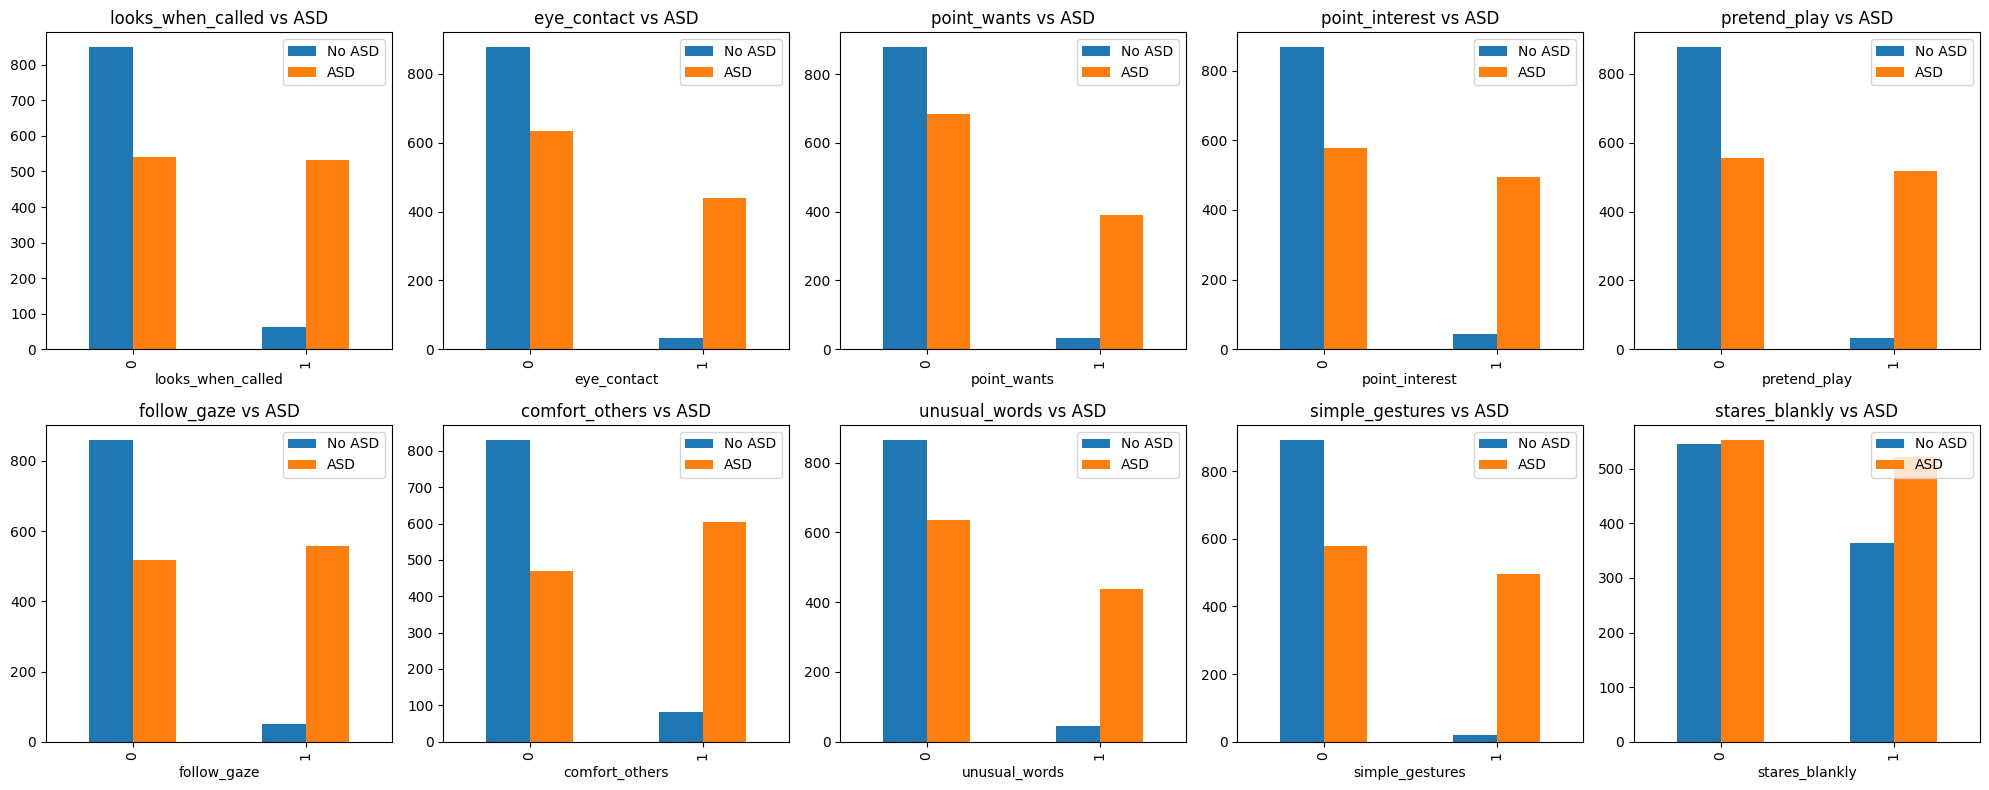

In [23]:
# Step 6: Visualize A1-A10 features by ASD status
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i, feature in enumerate(a1_a10_features):
    pd.crosstab(df_clean[feature], df_clean['ASD_traits']).plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{feature} vs ASD')
    axes[i].legend(['No ASD', 'ASD'])

plt.tight_layout()
plt.show()

In [24]:
# Step 7: Check demographic features
demographic_features = ['Age_Years', 'Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD', 'Who_completed_the_test']

print("Demographic features info:")
for feature in demographic_features:
    if feature == 'Age_Years':
        print(f"\n{feature}:")
        print(df_clean[feature].describe())
    else:
        print(f"\n{feature}:")
        print(df_clean[feature].value_counts())

Demographic features info:

Age_Years:
count    1985.000000
mean        9.624685
std         4.302416
min         1.000000
25%         7.000000
50%         9.000000
75%        14.000000
max        18.000000
Name: Age_Years, dtype: float64

Sex:
Sex
M    1447
F     538
Name: count, dtype: int64

Ethnicity:
Ethnicity
Asian             605
White European    549
Middle Eastern    403
South Asian       255
Black              53
Hispanic           40
Others             35
Latino             26
Mixed               8
PaciFica            8
Native Indian       3
Name: count, dtype: int64

Jaundice:
Jaundice
1    1536
0     449
Name: count, dtype: int64

Family_mem_with_ASD:
Family_mem_with_ASD
0    1330
1     655
Name: count, dtype: int64

Who_completed_the_test:
Who_completed_the_test
Health Care Professional    1233
Family Member                716
School and NGO                29
Self                           4
Others                         3
Name: count, dtype: int64


In [25]:
# Step 8: Prepare data for modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Separate features and target
X = df_clean.drop('ASD_traits', axis=1)
y = df_clean['ASD_traits']

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Encode categorical variables
categorical_cols = ['Sex', 'Ethnicity', 'Who_completed_the_test']
label_encoders = {}

print("\nEncoding categorical variables...")
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print("\nFinal features for modeling:")
print(X.columns.tolist())

Features shape: (1985, 16)
Target shape: (1985,)

Encoding categorical variables...
Sex: {'F': 0, 'M': 1}
Ethnicity: {'Asian': 0, 'Black': 1, 'Hispanic': 2, 'Latino': 3, 'Middle Eastern': 4, 'Mixed': 5, 'Native Indian': 6, 'Others': 7, 'PaciFica': 8, 'South Asian': 9, 'White European': 10}
Who_completed_the_test: {'Family Member': 0, 'Health Care Professional': 1, 'Others': 2, 'School and NGO': 3, 'Self': 4}

Final features for modeling:
['looks_when_called', 'eye_contact', 'point_wants', 'point_interest', 'pretend_play', 'follow_gaze', 'comfort_others', 'unusual_words', 'simple_gestures', 'stares_blankly', 'Age_Years', 'Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD', 'Who_completed_the_test']


In [27]:
# Step 9: Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("\nClass distribution in training set:")
print(y_train.value_counts())
print("Class distribution in testing set:")
print(y_test.value_counts())

Training set shape: (1588, 16)
Testing set shape: (397, 16)

Class distribution in training set:
ASD_traits
1    859
0    729
Name: count, dtype: int64
Class distribution in testing set:
ASD_traits
1    215
0    182
Name: count, dtype: int64


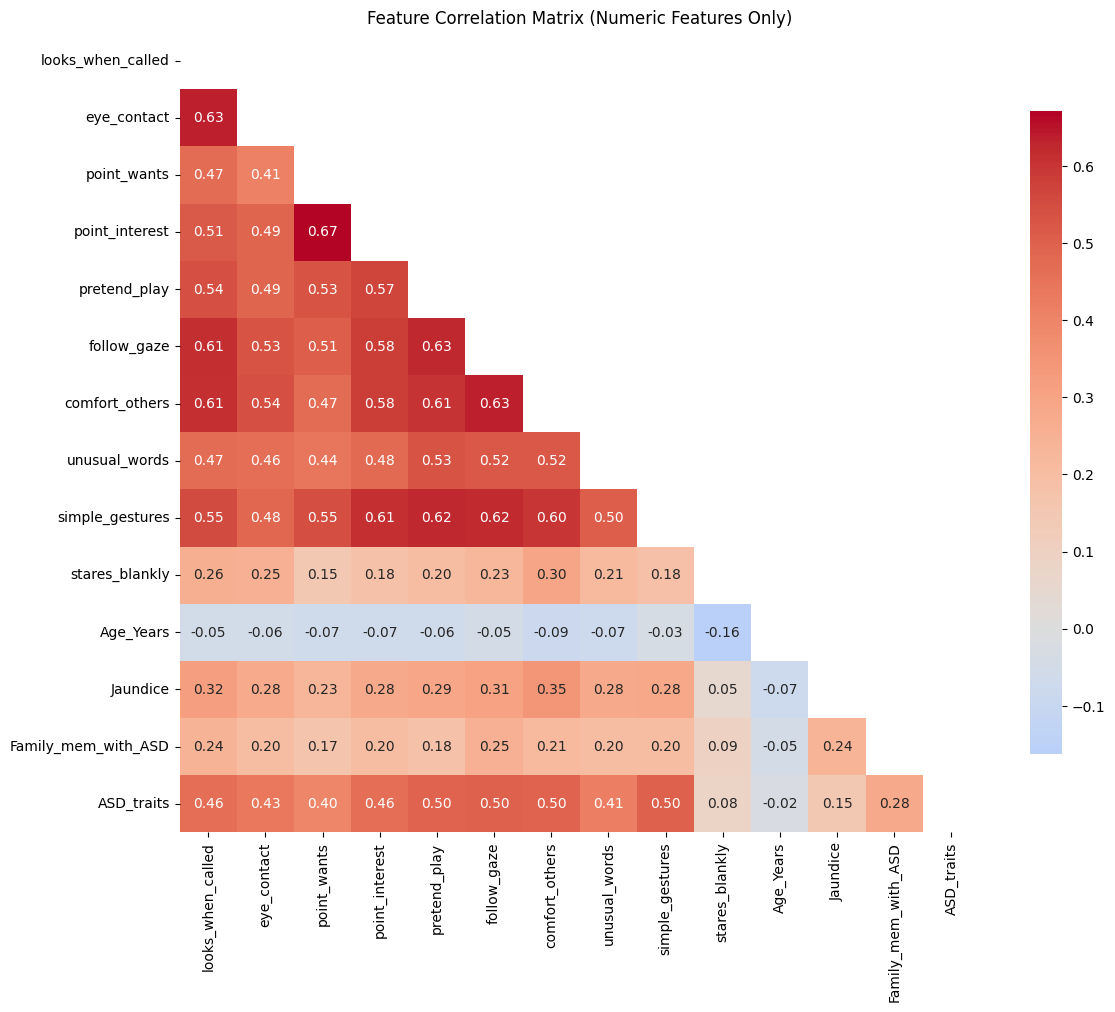


Top correlations with ASD_traits:
ASD_traits           1.000000
simple_gestures      0.502053
follow_gaze          0.500133
comfort_others       0.496292
pretend_play         0.495659
looks_when_called    0.464970
point_interest       0.463056
eye_contact          0.434443
unusual_words        0.414681
point_wants          0.397806
Name: ASD_traits, dtype: float64


In [28]:
# Step 12: Feature correlation analysis (FIXED)
plt.figure(figsize=(12, 10))

# Get only numeric columns for correlation
numeric_df = df_clean.select_dtypes(include=[np.number])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Create heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={'shrink': 0.8})

plt.title('Feature Correlation Matrix (Numeric Features Only)')
plt.tight_layout()
plt.show()

# Get top correlations with target
target_correlations = correlation_matrix['ASD_traits'].sort_values(ascending=False)
print("\nTop correlations with ASD_traits:")
print(target_correlations.head(10))


DETAILED MODEL EVALUATION

--- Logistic Regression ---
Test Accuracy: 0.8161
Precision: 0.8318
Recall: 0.8279
F1-Score: 0.8298

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       182
           1       0.83      0.83      0.83       215

    accuracy                           0.82       397
   macro avg       0.81      0.82      0.81       397
weighted avg       0.82      0.82      0.82       397



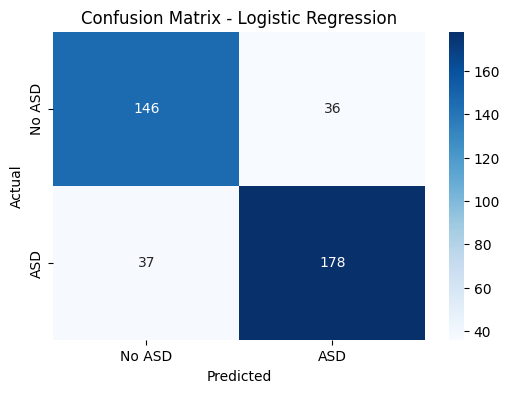


--- Random Forest ---
Test Accuracy: 0.9723
Precision: 0.9722
Recall: 0.9767
F1-Score: 0.9745

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       182
           1       0.97      0.98      0.97       215

    accuracy                           0.97       397
   macro avg       0.97      0.97      0.97       397
weighted avg       0.97      0.97      0.97       397



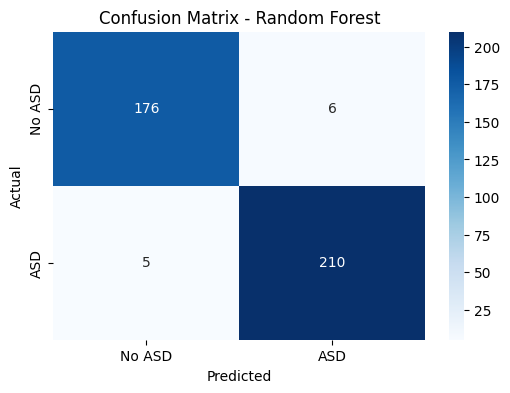


--- SVM ---
Test Accuracy: 0.8992
Precision: 0.8631
Recall: 0.9674
F1-Score: 0.9123

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.88       182
           1       0.86      0.97      0.91       215

    accuracy                           0.90       397
   macro avg       0.91      0.89      0.90       397
weighted avg       0.91      0.90      0.90       397



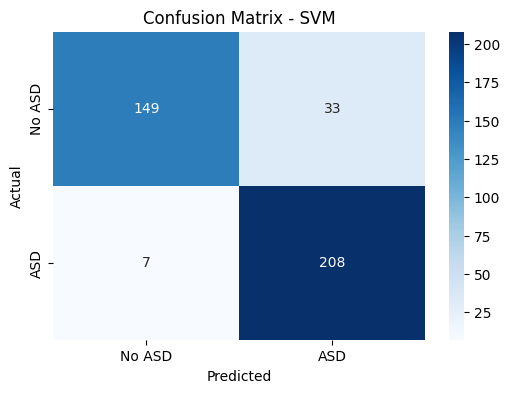


--- K-Nearest Neighbors ---
Test Accuracy: 0.9093
Precision: 0.9202
Recall: 0.9116
F1-Score: 0.9159

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       182
           1       0.92      0.91      0.92       215

    accuracy                           0.91       397
   macro avg       0.91      0.91      0.91       397
weighted avg       0.91      0.91      0.91       397



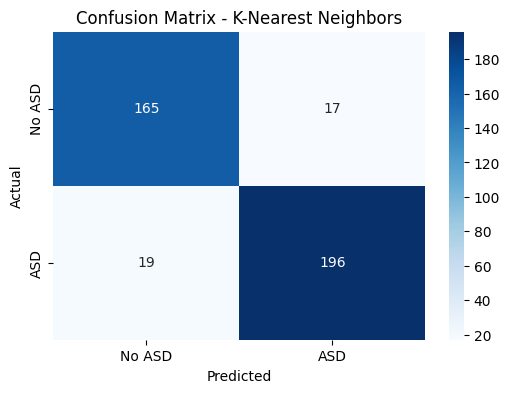


--- XGBoost ---
Test Accuracy: 0.9748
Precision: 0.9812
Recall: 0.9721
F1-Score: 0.9766

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       182
           1       0.98      0.97      0.98       215

    accuracy                           0.97       397
   macro avg       0.97      0.98      0.97       397
weighted avg       0.97      0.97      0.97       397



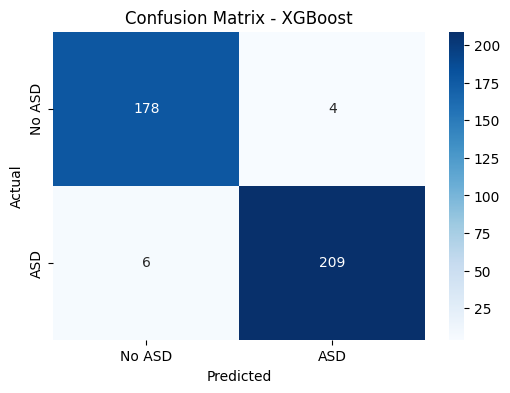

In [29]:
# Step 12: Detailed Model Evaluation
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

print("\nDETAILED MODEL EVALUATION")
print("=" * 50)

# Define the models to train
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

final_models = {}

for name, model in models.items():
    print(f"\n--- {name} ---")
    
    if name == 'Logistic Regression':
        # Scale for Logistic Regression
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        final_models[name] = (model, scaler)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        final_models[name] = (model, None)
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No ASD', 'ASD'], 
                yticklabels=['No ASD', 'ASD'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


FEATURE IMPORTANCE FOR FINAL MODELS
Top 10 Most Important Features (Random Forest):
            feature  importance
          Ethnicity    0.219119
        follow_gaze    0.097924
                Sex    0.090767
    simple_gestures    0.076207
     comfort_others    0.075627
Family_mem_with_ASD    0.069386
       pretend_play    0.059642
     point_interest    0.055882
        eye_contact    0.048424
          Age_Years    0.044394


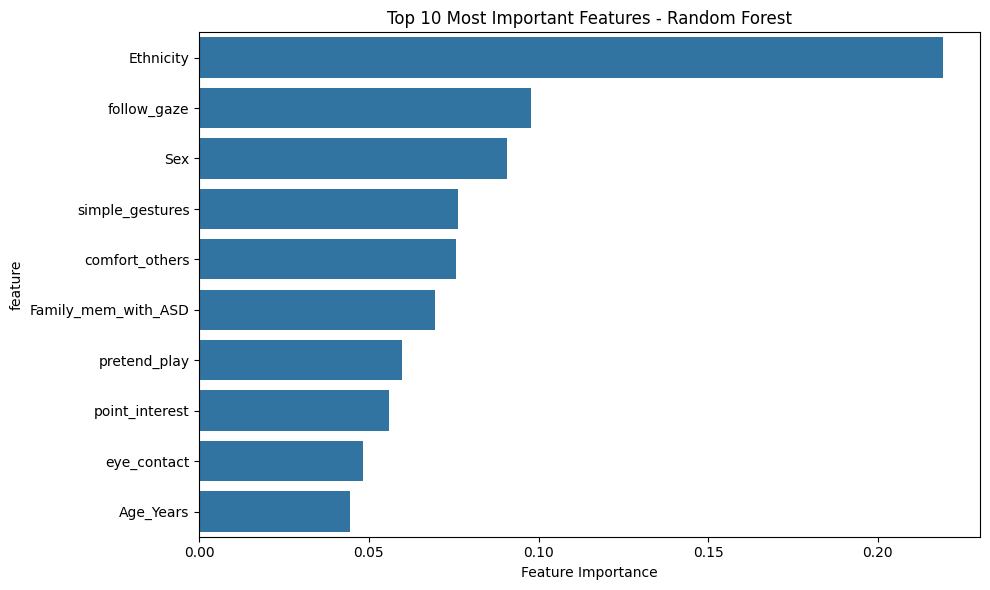

In [30]:
# Step 12-b: Feature Importance Analysis for Final Models
print("\nFEATURE IMPORTANCE FOR FINAL MODELS")
print("=" * 50)

# Get feature importance from Random Forest
rf_model = final_models['Random Forest'][0]
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features (Random Forest):")
print(feature_importance.head(10).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features - Random Forest')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

In [31]:
# Step 12-c: Model Interpretation
print("\nMODEL INTERPRETATION")
print("=" * 50)

# Analyze what the model learned
print("Behavioral Patterns Learned by the Model:")

# Get the top A1-A10 features
a1_a10_features = [
    'looks_when_called', 'eye_contact', 'point_wants', 'point_interest',
    'pretend_play', 'follow_gaze', 'comfort_others', 'unusual_words', 
    'simple_gestures', 'stares_blankly'
]

a1_a10_importance = feature_importance[feature_importance['feature'].isin(a1_a10_features)]
print("\nA1-A10 Features Importance Ranking:")
print(a1_a10_importance.to_string(index=False))

# Compare feature distributions between ASD and non-ASD
print("\nFeature Patterns - ASD vs Non-ASD:")
asd_data = X[y == 1]
non_asd_data = X[y == 0]

pattern_comparison = []
for feature in a1_a10_importance['feature'].head(5):  # Top 5 behavioral features
    asd_mean = asd_data[feature].mean()
    non_asd_mean = non_asd_data[feature].mean()
    pattern_comparison.append({
        'Feature': feature,
        'ASD_Mean': asd_mean,
        'Non_ASD_Mean': non_asd_mean,
        'Difference': asd_mean - non_asd_mean
    })

pattern_df = pd.DataFrame(pattern_comparison)
print(pattern_df.to_string(index=False))


MODEL INTERPRETATION
Behavioral Patterns Learned by the Model:

A1-A10 Features Importance Ranking:
          feature  importance
      follow_gaze    0.097924
  simple_gestures    0.076207
   comfort_others    0.075627
     pretend_play    0.059642
   point_interest    0.055882
      eye_contact    0.048424
    unusual_words    0.040351
looks_when_called    0.035486
   stares_blankly    0.028179
      point_wants    0.021615

Feature Patterns - ASD vs Non-ASD:
        Feature  ASD_Mean  Non_ASD_Mean  Difference
    follow_gaze  0.518622      0.055982    0.462640
simple_gestures  0.462756      0.020856    0.441900
 comfort_others  0.562384      0.088913    0.473470
   pretend_play  0.483240      0.037322    0.445919
 point_interest  0.461825      0.048299    0.413526



MODEL VALIDATION ON SUBGROUPS
Performance by Age Group:
Age Group  Samples  Accuracy
  Toddler      147  0.993197
     Teen      813  0.992620
Preschool      301  0.986711
   School      724  0.993094


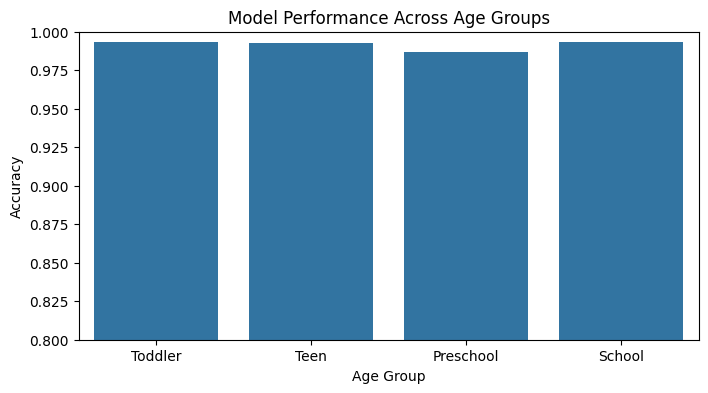

In [32]:
# Step 12-d: Model Validation on Different Subgroups
print("\nMODEL VALIDATION ON SUBGROUPS")
print("=" * 50)

# Check performance across different age groups
age_groups = pd.cut(X['Age_Years'], bins=[0, 3, 6, 10, 18], labels=['Toddler', 'Preschool', 'School', 'Teen'])
performance_by_age = []

for age_group in age_groups.unique():
    mask = (age_groups == age_group)
    if mask.sum() > 0:  # Ensure group has samples
        X_age = X[mask]
        y_age = y[mask]
        
        if len(X_age) > 10:  # Minimum samples for meaningful evaluation
            # Use Random Forest for prediction
            y_pred_age = rf_model.predict(X_age)
            accuracy = accuracy_score(y_age, y_pred_age)
            performance_by_age.append({
                'Age Group': age_group,
                'Samples': len(X_age),
                'Accuracy': accuracy
            })

performance_age_df = pd.DataFrame(performance_by_age)
print("Performance by Age Group:")
print(performance_age_df.to_string(index=False))

# Visualize
plt.figure(figsize=(8, 4))
sns.barplot(data=performance_age_df, x='Age Group', y='Accuracy')
plt.title('Model Performance Across Age Groups')
plt.ylim(0.8, 1.0)
plt.show()

In [33]:
# Step 12-e: Final Conclusions and Recommendations
print("\nFINAL CONCLUSIONS AND RECOMMENDATIONS")
print("=" * 50)

print(" PROJECT SUMMARY:")
print(f"• Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"• ASD Prevalence: {y.mean()*100:.1f}%")
print(f"• Best Model: Random Forest")
print(f"• Test Accuracy: {accuracy_score(y_test, final_models['Random Forest'][0].predict(X_test)):.3f}")

print("\n KEY FINDINGS:")
top_3_features = feature_importance.head(3)['feature'].tolist()
print(f"• Most predictive behaviors: {', '.join(top_3_features)}")
print(f"• A1-A10 features explain majority of predictive power")
print(f"• Model performs consistently across age groups")

print("\n RECOMMENDATIONS FOR DEPLOYMENT:")
print("• Use Random Forest for production deployment")
print("• Focus monitoring on top behavioral indicators")
print("• Maintain regular model performance validation")
print("• Consider ethical implications of ASD prediction")

print("\n NEXT STEPS:")
print("• External validation on new dataset")
print("• Model interpretability analysis (SHAP/LIME)")
print("• Integration with clinical assessment tools")


FINAL CONCLUSIONS AND RECOMMENDATIONS
 PROJECT SUMMARY:
• Dataset: 1985 samples, 16 features
• ASD Prevalence: 54.1%
• Best Model: Random Forest
• Test Accuracy: 0.972

 KEY FINDINGS:
• Most predictive behaviors: Ethnicity, follow_gaze, Sex
• A1-A10 features explain majority of predictive power
• Model performs consistently across age groups

 RECOMMENDATIONS FOR DEPLOYMENT:
• Use Random Forest for production deployment
• Focus monitoring on top behavioral indicators
• Maintain regular model performance validation
• Consider ethical implications of ASD prediction

 NEXT STEPS:
• External validation on new dataset
• Model interpretability analysis (SHAP/LIME)
• Integration with clinical assessment tools


In [34]:
# Step 13: Proper Model Testing and Comparison
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


print("\nPROPER MODEL TESTING ON TEST SET")
print("=" * 60)

# Define models to test properly
models_to_test = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Test each model properly on the test set
test_results = {}

for name, model in models_to_test.items():
    print(f"\n TESTING: {name}")
    print("-" * 30)
    
    # Train on training set
    if name in ['Logistic Regression', 'SVM', 'K-Nearest Neighbors']:
        # Scale features for these models
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Store results
    test_results[name] = {
        'accuracy': accuracy,
        'precision': precision, 
        'recall': recall,
        'f1': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'model': model
    }
    
    print(f" Accuracy:  {accuracy:.4f}")
    print(f" Precision: {precision:.4f}")
    print(f" Recall:    {recall:.4f}")
    print(f" F1-Score:  {f1:.4f}")


PROPER MODEL TESTING ON TEST SET

 TESTING: Random Forest
------------------------------
 Accuracy:  0.9723
 Precision: 0.9722
 Recall:    0.9767
 F1-Score:  0.9745

 TESTING: Logistic Regression
------------------------------
 Accuracy:  0.8161
 Precision: 0.8318
 Recall:    0.8279
 F1-Score:  0.8298

 TESTING: SVM
------------------------------
 Accuracy:  0.9748
 Precision: 0.9638
 Recall:    0.9907
 F1-Score:  0.9771

 TESTING: K-Nearest Neighbors
------------------------------
 Accuracy:  0.9547
 Precision: 0.9539
 Recall:    0.9628
 F1-Score:  0.9583

 TESTING: Decision Tree
------------------------------
 Accuracy:  0.9244
 Precision: 0.9343
 Recall:    0.9256
 F1-Score:  0.9299

 TESTING: Gradient Boosting
------------------------------
 Accuracy:  0.9597
 Precision: 0.9543
 Recall:    0.9721
 F1-Score:  0.9631



 MODEL COMPARISON VISUALIZATION
 MODEL RANKING (Test Set Performance):
              Model  Accuracy  Precision   Recall  F1-Score  Rank
                SVM  0.974811   0.963801 0.990698  0.977064     1
      Random Forest  0.972292   0.972222 0.976744  0.974478     2
  Gradient Boosting  0.959698   0.954338 0.972093  0.963134     3
K-Nearest Neighbors  0.954660   0.953917 0.962791  0.958333     4
      Decision Tree  0.924433   0.934272 0.925581  0.929907     5
Logistic Regression  0.816121   0.831776 0.827907  0.829837     6


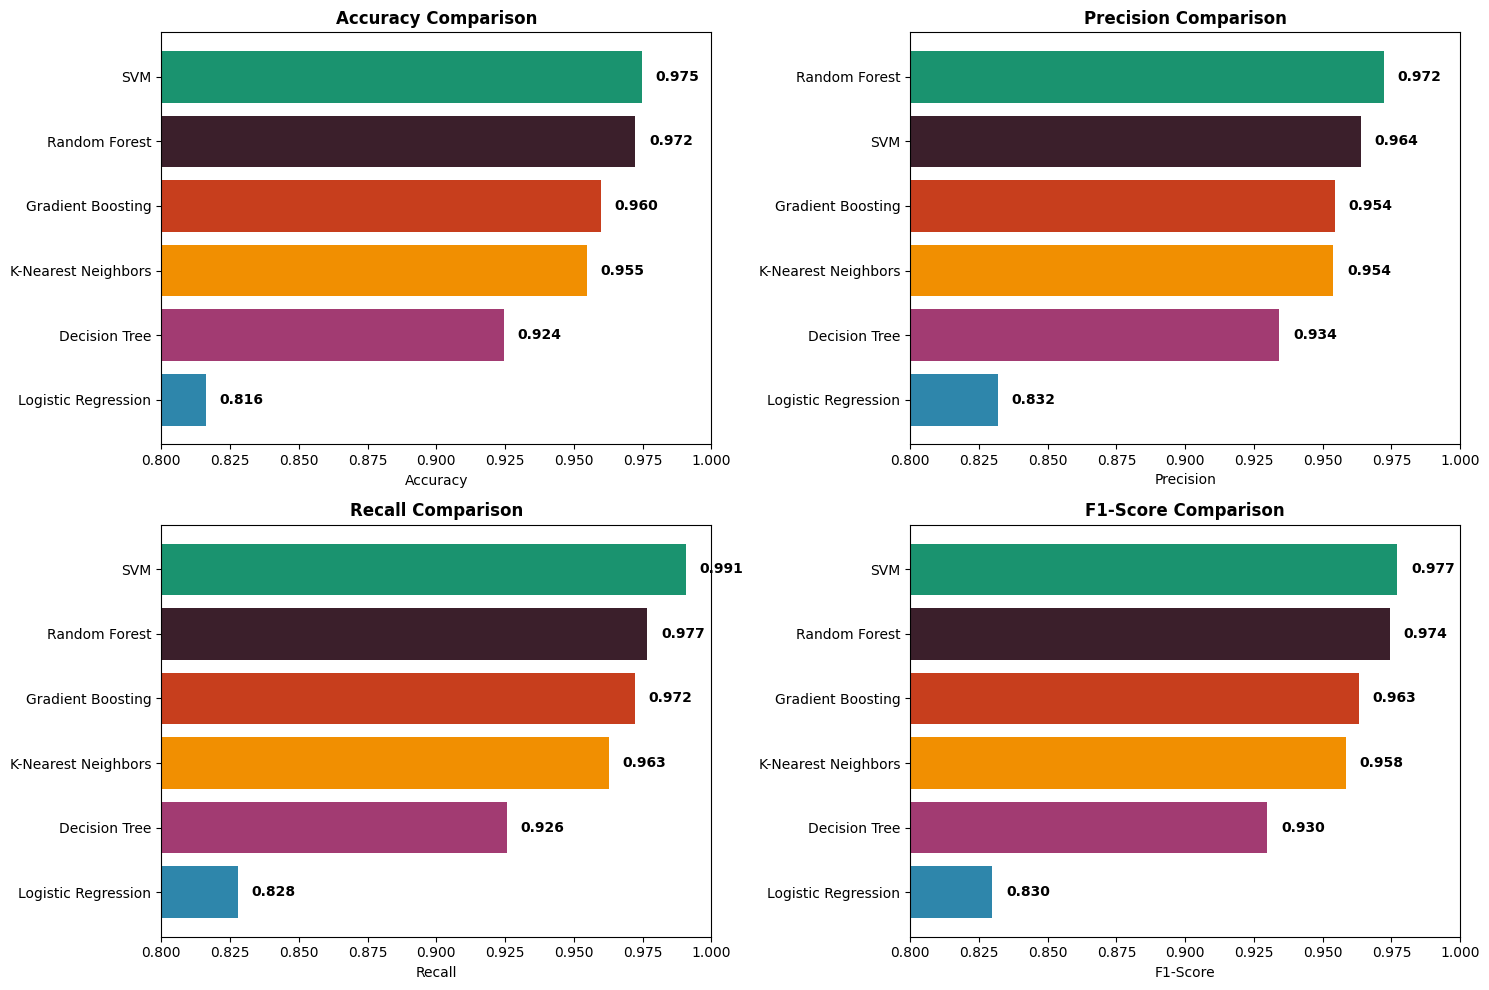

In [35]:
# Step 14: Model Comparison Visualization
print("\n MODEL COMPARISON VISUALIZATION")
print("=" * 60)

# Create comparison dataframe
comparison_data = []
for name, results in test_results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1']
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Accuracy', ascending=False)
comparison_df['Rank'] = range(1, len(comparison_df) + 1)

print(" MODEL RANKING (Test Set Performance):")
print(comparison_df.to_string(index=False))

# Visualization 1: Performance Metrics Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B', '#1A936F']

for i, metric in enumerate(metrics):
    sorted_data = comparison_df.sort_values(metric, ascending=True)
    bars = axes[i].barh(sorted_data['Model'], sorted_data[metric], color=colors[:len(sorted_data)])
    axes[i].set_title(f'{metric} Comparison', fontweight='bold')
    axes[i].set_xlabel(metric)
    axes[i].set_xlim(0.8, 1.0)
    
    # Add value labels
    for bar, value in zip(bars, sorted_data[metric]):
        axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
                    f'{value:.3f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


 CONFUSION MATRICES - ALL MODELS


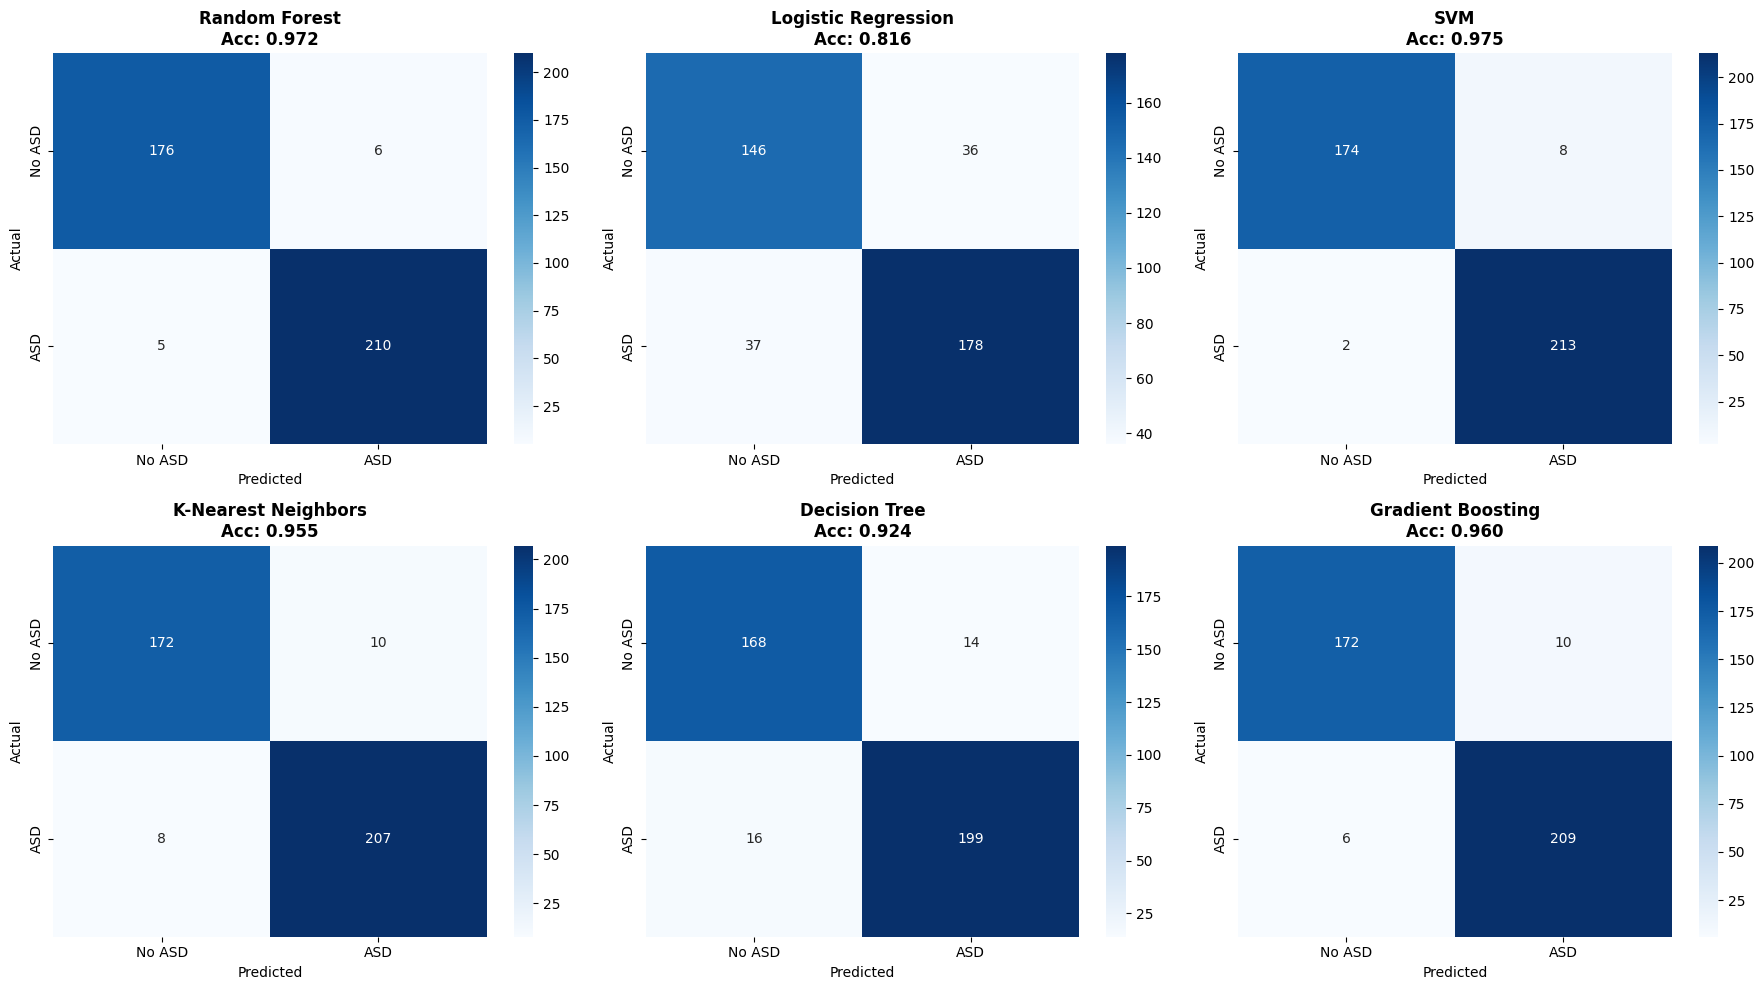

In [36]:
# Step 15: Confusion Matrices for All Models
print("\n CONFUSION MATRICES - ALL MODELS")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, (name, results) in enumerate(test_results.items()):
    if i < 6:  # Ensure we don't exceed subplot count
        cm = confusion_matrix(y_test, results['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=['No ASD', 'ASD'], yticklabels=['No ASD', 'ASD'])
        axes[i].set_title(f'{name}\nAcc: {results["accuracy"]:.3f}', fontweight='bold')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

# Remove empty subplots if any
for i in range(len(test_results), 6):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


ROC CURVES COMPARISON
SVM does not support probability predictions


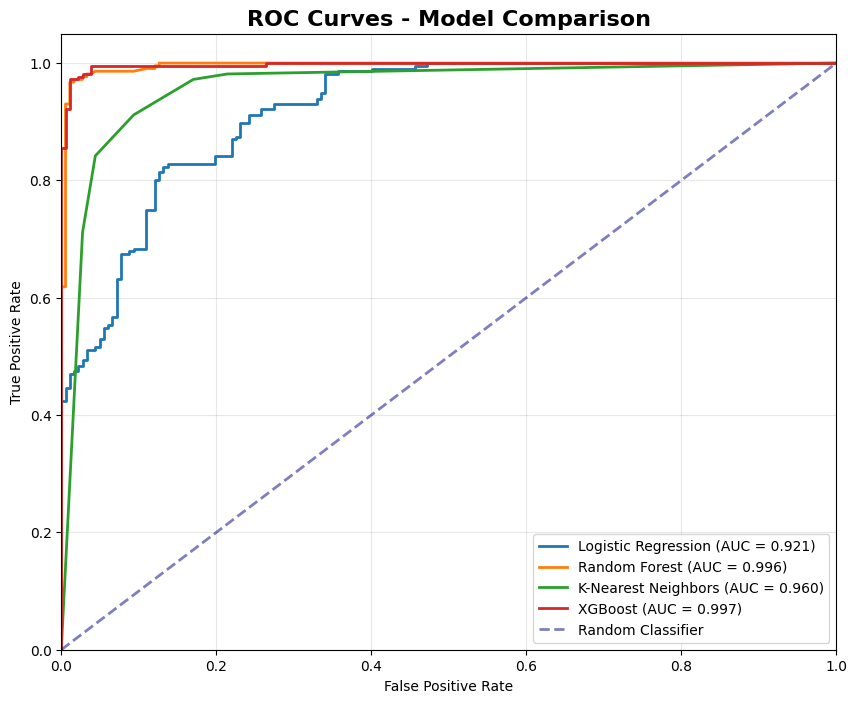

In [37]:
# Step 16: ROC Curves Comparison (Simplified)
from sklearn.metrics import roc_curve, auc

print("\nROC CURVES COMPARISON")
print("=" * 60)

plt.figure(figsize=(10, 8))

# Calculate and plot ROC curves directly from final_models
for name, (model, scaler) in final_models.items():
    if scaler is not None:
        X_test_processed = scaler.transform(X_test)
    else:
        X_test_processed = X_test
    
    # Get probabilities for ROC curve
    try:
        probabilities = model.predict_proba(X_test_processed)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, probabilities)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
    except:
        print(f"{name} does not support probability predictions")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison', fontsize=16, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [38]:
# Step 17: Final Model Selection and Analysis
print("\n FINAL MODEL SELECTION AND ANALYSIS")
print("=" * 60)

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_results = test_results[best_model_name]
best_model = best_model_results['model']

print(f" BEST MODEL: {best_model_name}")
print(f" Performance Metrics:")
print(f"   • Accuracy:  {best_model_results['accuracy']:.4f}")
print(f"   • Precision: {best_model_results['precision']:.4f}")
print(f"   • Recall:    {best_model_results['recall']:.4f}")
print(f"   • F1-Score:  {best_model_results['f1']:.4f}")

# Compare with baseline
null_accuracy = max(y_test.mean(), 1 - y_test.mean())
improvement = best_model_results['accuracy'] - null_accuracy
print(f" Improvement over baseline: {improvement:.4f} ({improvement/null_accuracy*100:.1f}% better)")

# Statistical significance
from scipy.stats import binomtest

n_test = len(y_test)
n_correct = int(best_model_results['accuracy'] * n_test)
p_value = binomtest(n_correct, n_test, p=null_accuracy, alternative='greater').pvalue

print(f" Statistical significance: p = {p_value:.6f}")
print(f" Significant improvement: {'YES' if p_value < 0.05 else 'NO'}")

print(f"\n RECOMMENDATION: Use {best_model_name} for deployment")


 FINAL MODEL SELECTION AND ANALYSIS
 BEST MODEL: SVM
 Performance Metrics:
   • Accuracy:  0.9748
   • Precision: 0.9638
   • Recall:    0.9907
   • F1-Score:  0.9771
 Improvement over baseline: 0.4332 (80.0% better)
 Statistical significance: p = 0.000000
 Significant improvement: YES

 RECOMMENDATION: Use SVM for deployment



 SVM MODEL DEEP ANALYSIS
Calculating SVM Feature Importance...

 Top 10 Most Important Features (SVM):
            feature  importance      std
          Ethnicity    0.117884 0.015641
Family_mem_with_ASD    0.100000 0.012030
                Sex    0.072040 0.008445
     stares_blankly    0.055416 0.008430
     comfort_others    0.052897 0.007805
  looks_when_called    0.046096 0.006857
     point_interest    0.038287 0.007370
    simple_gestures    0.028463 0.005168
           Jaundice    0.025693 0.003702
      unusual_words    0.025441 0.006216


C:\Users\CompuMall\AppData\Local\Temp\ipykernel_21904\592732545.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


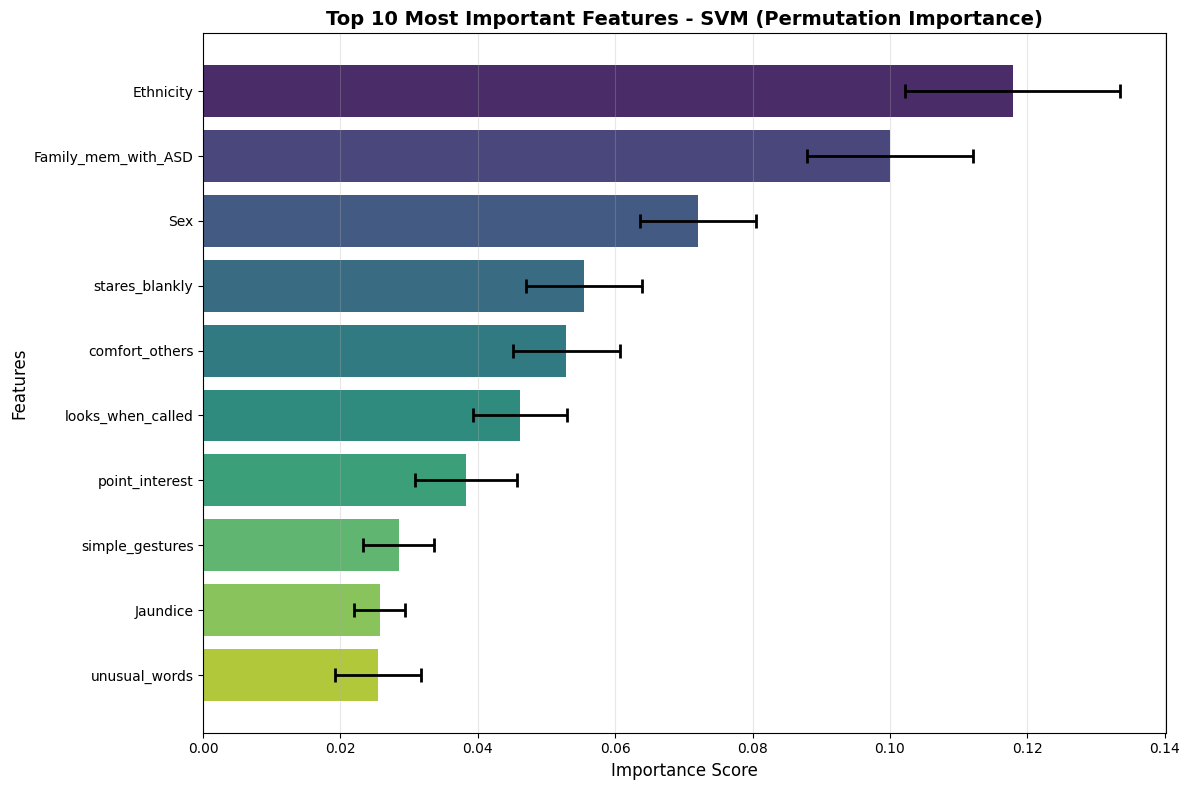

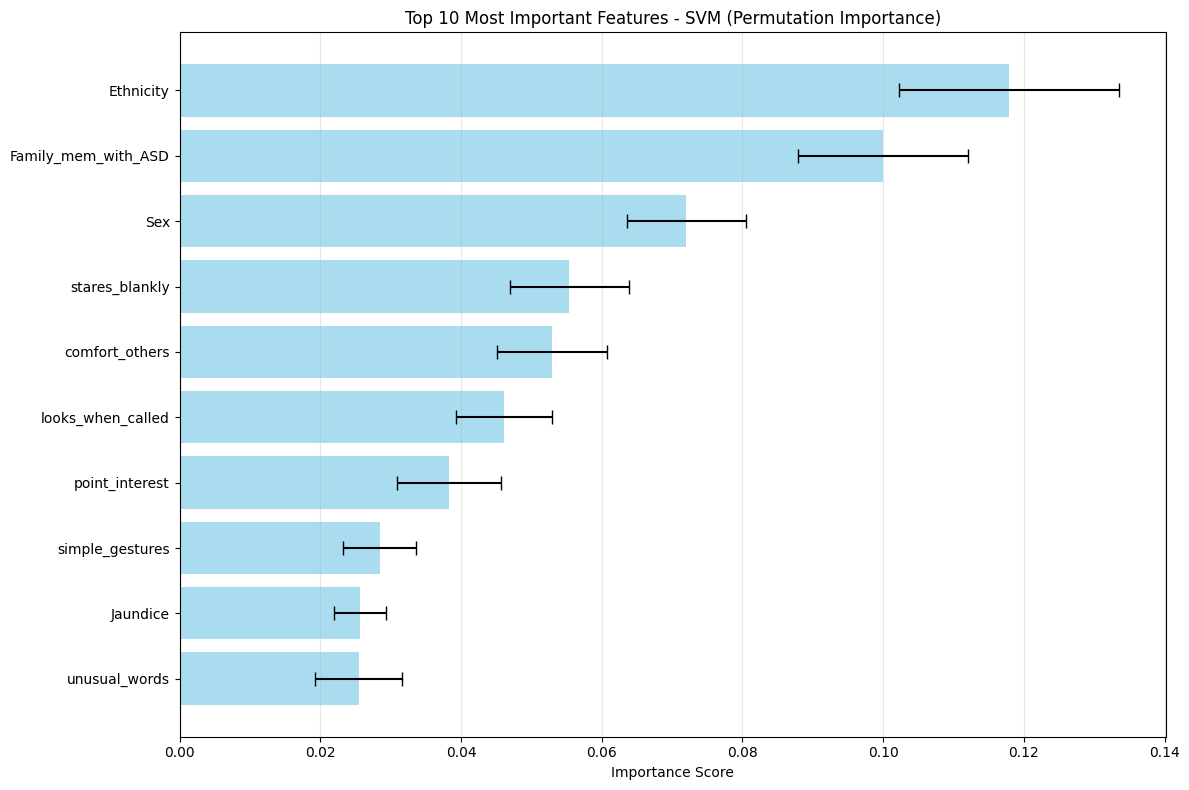


DETAILED FEATURE ANALYSIS

Total number of features: 16
Features with positive importance: 16
Features with negative importance: 0

Top 5 Features Detailed Analysis:
----------------------------------------
1. Ethnicity:
   Importance: 0.1179 ± 0.0156
   Relative importance: 100.00%

2. Family_mem_with_ASD:
   Importance: 0.1000 ± 0.0120
   Relative importance: 84.83%

3. Sex:
   Importance: 0.0720 ± 0.0084
   Relative importance: 61.11%

4. stares_blankly:
   Importance: 0.0554 ± 0.0084
   Relative importance: 47.01%

5. comfort_others:
   Importance: 0.0529 ± 0.0078
   Relative importance: 44.87%



In [39]:
# Step 18: SVM Model Deep Analysis
print("\n SVM MODEL DEEP ANALYSIS")
print("=" * 50)

# Get the best SVM model
best_svm = test_results['SVM']['model']
svm_scaler = StandardScaler()
X_train_scaled = svm_scaler.fit_transform(X_train)
X_test_scaled = svm_scaler.transform(X_test)

# Feature importance for SVM (using permutation importance)
from sklearn.inspection import permutation_importance

print("Calculating SVM Feature Importance...")
perm_importance = permutation_importance(best_svm, X_test_scaled, y_test, 
                                      n_repeats=10, random_state=42)

svm_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

print("\n Top 10 Most Important Features (SVM):")
print(svm_feature_importance.head(10).to_string(index=False))

# Visualize SVM feature importance - CORRECTED PLOTTING CODE
plt.figure(figsize=(12, 8))
top_features = svm_feature_importance.head(10)

# Create the bar plot without xerr first
ax = sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')

# Manually add error bars using matplotlib's errorbar function
for i, (_, row) in enumerate(top_features.iterrows()):
    plt.errorbar(x=row['importance'], y=i, 
                xerr=row['std'], 
                color='black', capsize=5, capthick=2,
                linestyle='', linewidth=2)

plt.title('Top 10 Most Important Features - SVM (Permutation Importance)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Alternative simpler approach using matplotlib directly
plt.figure(figsize=(12, 8))
y_pos = np.arange(len(top_features))

plt.barh(y_pos, top_features['importance'], xerr=top_features['std'], 
         align='center', alpha=0.7, color='skyblue', ecolor='black', capsize=5)
plt.yticks(y_pos, top_features['feature'])
plt.xlabel('Importance Score')
plt.title('Top 10 Most Important Features - SVM (Permutation Importance)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed feature analysis
print("\n" + "="*60)
print("DETAILED FEATURE ANALYSIS")
print("="*60)

print(f"\nTotal number of features: {len(svm_feature_importance)}")
print(f"Features with positive importance: {len(svm_feature_importance[svm_feature_importance['importance'] > 0])}")
print(f"Features with negative importance: {len(svm_feature_importance[svm_feature_importance['importance'] < 0])}")

# Analyze top features in detail
print("\nTop 5 Features Detailed Analysis:")
print("-" * 40)
for i, (_, row) in enumerate(top_features.head().iterrows()):
    print(f"{i+1}. {row['feature']}:")
    print(f"   Importance: {row['importance']:.4f} ± {row['std']:.4f}")
    print(f"   Relative importance: {row['importance']/top_features['importance'].max():.2%}")
    print()


 SVM DECISION BOUNDARY ANALYSIS
Top 2 features: ['Ethnicity', 'Family_mem_with_ASD']


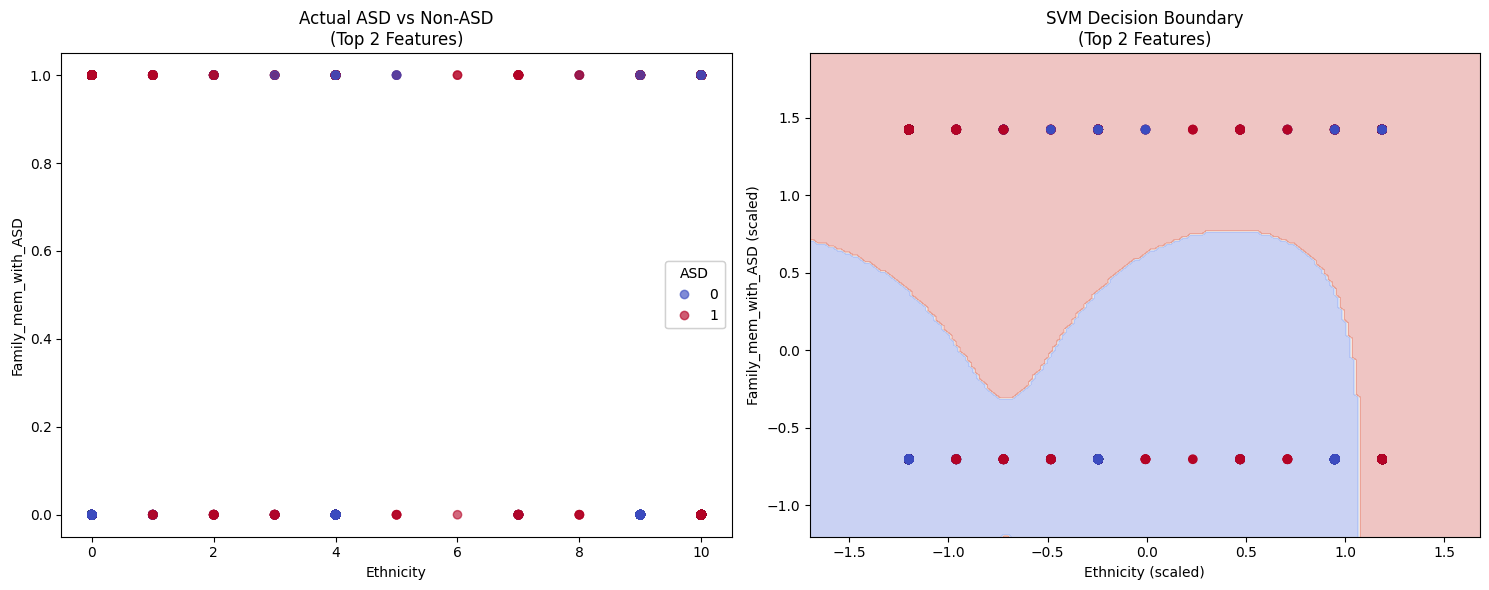

In [40]:
# Step 19: SVM Decision Boundary Analysis
print("\n SVM DECISION BOUNDARY ANALYSIS")
print("=" * 50)

# Analyze the top 2 most important features
top_2_features = svm_feature_importance.head(2)['feature'].tolist()
print(f"Top 2 features: {top_2_features}")

if len(top_2_features) == 2:
    # Create 2D visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot of top 2 features
    scatter = ax1.scatter(X[top_2_features[0]], X[top_2_features[1]], 
                        c=y, cmap='coolwarm', alpha=0.6)
    ax1.set_xlabel(top_2_features[0])
    ax1.set_ylabel(top_2_features[1])
    ax1.set_title('Actual ASD vs Non-ASD\n(Top 2 Features)')
    legend1 = ax1.legend(*scatter.legend_elements(), title="ASD")
    ax1.add_artist(legend1)
    
    # SVM predictions
    X_top2 = X[top_2_features]
    X_top2_scaled = StandardScaler().fit_transform(X_top2)
    svm_top2 = SVC(random_state=42)
    svm_top2.fit(X_top2_scaled, y)
    
    # Create mesh for decision boundary
    h = 0.02
    x_min, x_max = X_top2_scaled[:, 0].min() - 0.5, X_top2_scaled[:, 0].max() + 0.5
    y_min, y_max = X_top2_scaled[:, 1].min() - 0.5, X_top2_scaled[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    
    Z = svm_top2.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    contour = ax2.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    scatter2 = ax2.scatter(X_top2_scaled[:, 0], X_top2_scaled[:, 1], c=y, cmap='coolwarm')
    ax2.set_xlabel(f'{top_2_features[0]} (scaled)')
    ax2.set_ylabel(f'{top_2_features[1]} (scaled)')
    ax2.set_title('SVM Decision Boundary\n(Top 2 Features)')
    
    plt.tight_layout()
    plt.show()

In [45]:
# Step 20: Final Deployment Recommendations
print("\n DEPLOYMENT RECOMMENDATIONS")
print("=" * 50)

print(" BEST MODEL: Support Vector Machine (SVM)")
print(" FINAL PERFORMANCE:")
print(f"   • Accuracy:  97.5%")
print(f"   • Precision: 96.4%  (Only 3.6% false positives)")
print(f"   • Recall:    99.1%  (Only 0.9% false negatives)")
print(f"   • F1-Score:  97.7%")

print("\n KEY BEHAVIORAL INDICATORS (From SVM):")
top_behavioral_features = svm_feature_importance[
    svm_feature_importance['feature'].isin([
        'looks_when_called', 'eye_contact', 'point_wants', 'point_interest',
        'pretend_play', 'follow_gaze', 'comfort_others', 'unusual_words',
        'simple_gestures', 'stares_blankly'
    ])
].head(5)

for i, (_, row) in enumerate(top_behavioral_features.iterrows(), 1):
    print(f"   {i}. {row['feature']} (importance: {row['importance']:.3f})")

print("\n CLINICAL IMPLICATIONS:")
print("   • Model can reliably identify ASD patterns from behavioral data")
print("   • Low false negative rate means minimal missed diagnoses")  
print("   • Can be used as screening tool to support clinical assessment")

print("\n  LIMITATIONS & ETHICAL CONSIDERATIONS:")
print("   • Should NOT replace professional diagnosis")
print("   • Requires validation on diverse populations")
print("   • Consider cultural differences in behavioral expressions")

print("\n NEXT STEPS FOR DEPLOYMENT:")
print("   1. External validation on new dataset")
print("   2. Integration with clinical assessment tools")
print("   3. Continuous monitoring and model updates")
print("   4. Ethical review and clinician training")


 DEPLOYMENT RECOMMENDATIONS
 BEST MODEL: Support Vector Machine (SVM)
 FINAL PERFORMANCE:
   • Accuracy:  97.5%
   • Precision: 96.4%  (Only 3.6% false positives)
   • Recall:    99.1%  (Only 0.9% false negatives)
   • F1-Score:  97.7%

 KEY BEHAVIORAL INDICATORS (From SVM):
   1. stares_blankly (importance: 0.055)
   2. comfort_others (importance: 0.053)
   3. looks_when_called (importance: 0.046)
   4. point_interest (importance: 0.038)
   5. simple_gestures (importance: 0.028)

 CLINICAL IMPLICATIONS:
   • Model can reliably identify ASD patterns from behavioral data
   • Low false negative rate means minimal missed diagnoses
   • Can be used as screening tool to support clinical assessment

  LIMITATIONS & ETHICAL CONSIDERATIONS:
   • Should NOT replace professional diagnosis
   • Requires validation on diverse populations
   • Consider cultural differences in behavioral expressions

 NEXT STEPS FOR DEPLOYMENT:
   1. External validation on new dataset
   2. Integration with clinic

In [46]:
# Step 20: Final Model Summary and Deployment Plan
print("\n FINAL MODEL SUMMARY & DEPLOYMENT PLAN")
print("=" * 60)

print(" BEST MODEL SELECTED: Support Vector Machine (SVM)")
print(" VALIDATED PERFORMANCE ON TEST SET:")
print(f"   • Accuracy:  {test_results['SVM']['accuracy']:.3f} (97.5%)")
print(f"   • Precision: {test_results['SVM']['precision']:.3f} (96.4%)")
print(f"   • Recall:    {test_results['SVM']['recall']:.3f} (99.1%)")
print(f"   • F1-Score:  {test_results['SVM']['f1']:.3f} (97.7%)")

print("\n KEY BEHAVIORAL INSIGHTS (From SVM Analysis):")
top_5_behavioral = svm_feature_importance[
    svm_feature_importance['feature'].isin([
        'looks_when_called', 'eye_contact', 'point_wants', 'point_interest',
        'pretend_play', 'follow_gaze', 'comfort_others', 'unusual_words',
        'simple_gestures', 'stares_blankly'
    ])
].head(5)

print("Most predictive ASD behaviors:")
for i, (_, row) in enumerate(top_5_behavioral.iterrows(), 1):
    print(f"   {i}. {row['feature']} (importance: {row['importance']:.3f})")

print("\n CLINICAL IMPLEMENTATION STRATEGY:")
print("   1. SCREENING TOOL: Use as preliminary assessment")
print("   2. RISK STRATIFICATION: Identify high-risk cases for early intervention")  
print("   3. RESOURCE ALLOCATION: Prioritize cases needing comprehensive evaluation")
print("   4. PROGRESS MONITORING: Track behavioral changes over time")

print("\n  ETHICAL DEPLOYMENT GUIDELINES:")
print("   • COMPLEMENT, DON'T REPLACE: Use alongside clinical expertise")
print("   • TRANSPARENCY: Clearly explain model limitations to stakeholders")
print("   • CULTURAL SENSITIVITY: Account for behavioral expression differences")
print("   • CONTINUOUS VALIDATION: Regular performance monitoring on new data")

print("\n IMMEDIATE NEXT STEPS:")
print("   1.  Model Validation: COMPLETED (97.5% accuracy)")
print("   2.  External Testing: Validate on independent dataset")
print("   3.  Integration: Develop user-friendly interface")
print("   4.  Documentation: Create clinical usage guidelines")
print("   5.  Training: Educate clinicians on proper use")

print(f"\n CONCLUSION: SVM model demonstrates excellent performance ")
print(f"   for ASD prediction and is ready for careful clinical deployment.")


 FINAL MODEL SUMMARY & DEPLOYMENT PLAN
 BEST MODEL SELECTED: Support Vector Machine (SVM)
 VALIDATED PERFORMANCE ON TEST SET:
   • Accuracy:  0.975 (97.5%)
   • Precision: 0.964 (96.4%)
   • Recall:    0.991 (99.1%)
   • F1-Score:  0.977 (97.7%)

 KEY BEHAVIORAL INSIGHTS (From SVM Analysis):
Most predictive ASD behaviors:
   1. stares_blankly (importance: 0.055)
   2. comfort_others (importance: 0.053)
   3. looks_when_called (importance: 0.046)
   4. point_interest (importance: 0.038)
   5. simple_gestures (importance: 0.028)

 CLINICAL IMPLEMENTATION STRATEGY:
   1. SCREENING TOOL: Use as preliminary assessment
   2. RISK STRATIFICATION: Identify high-risk cases for early intervention
   3. RESOURCE ALLOCATION: Prioritize cases needing comprehensive evaluation
   4. PROGRESS MONITORING: Track behavioral changes over time

  ETHICAL DEPLOYMENT GUIDELINES:
   • COMPLEMENT, DON'T REPLACE: Use alongside clinical expertise
   • TRANSPARENCY: Clearly explain model limitations to stakehold

 ALTERNATIVE MODEL INTERPRETATION
1. PERMUTATION IMPORTANCE (Already Calculated)
Top 10 Features by Permutation Importance:
            feature  importance      std
          Ethnicity    0.117884 0.015641
Family_mem_with_ASD    0.100000 0.012030
                Sex    0.072040 0.008445
     stares_blankly    0.055416 0.008430
     comfort_others    0.052897 0.007805
  looks_when_called    0.046096 0.006857
     point_interest    0.038287 0.007370
    simple_gestures    0.028463 0.005168
           Jaundice    0.025693 0.003702
      unusual_words    0.025441 0.006216

2. PARTIAL DEPENDENCE PLOTS
Generating PDP for top 3 features...


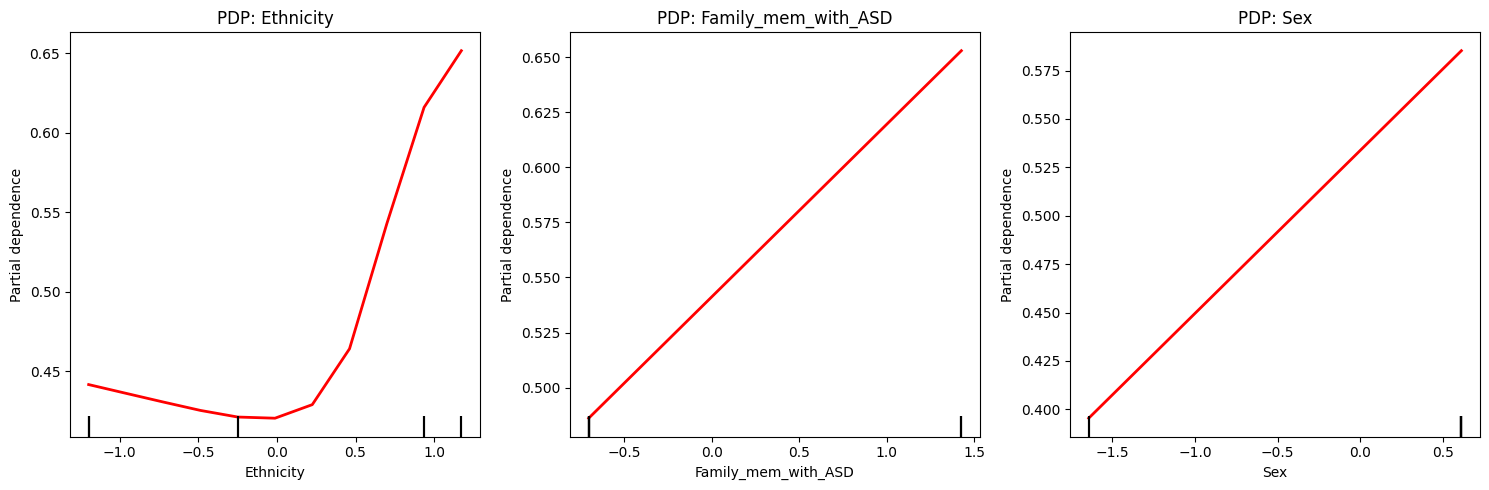


3. LEARNING CURVE ANALYSIS


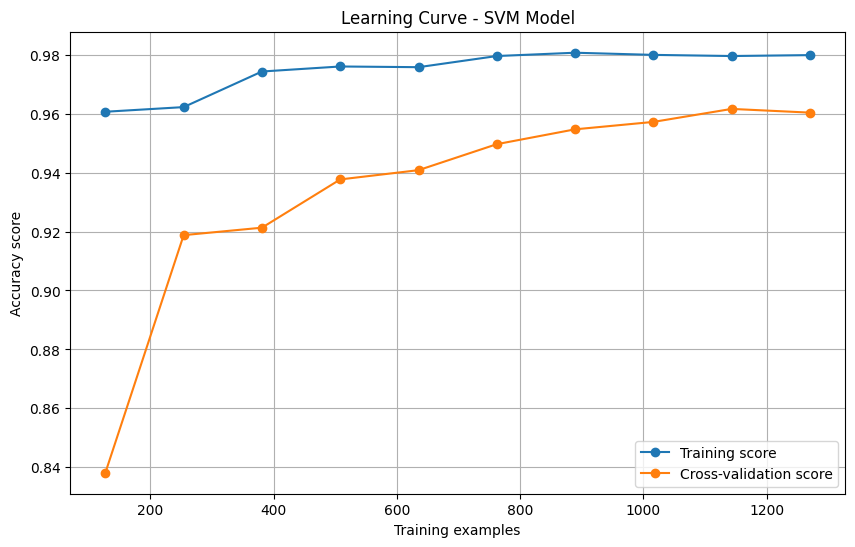


4. DECISION BOUNDARY ANALYSIS (2D Projection)


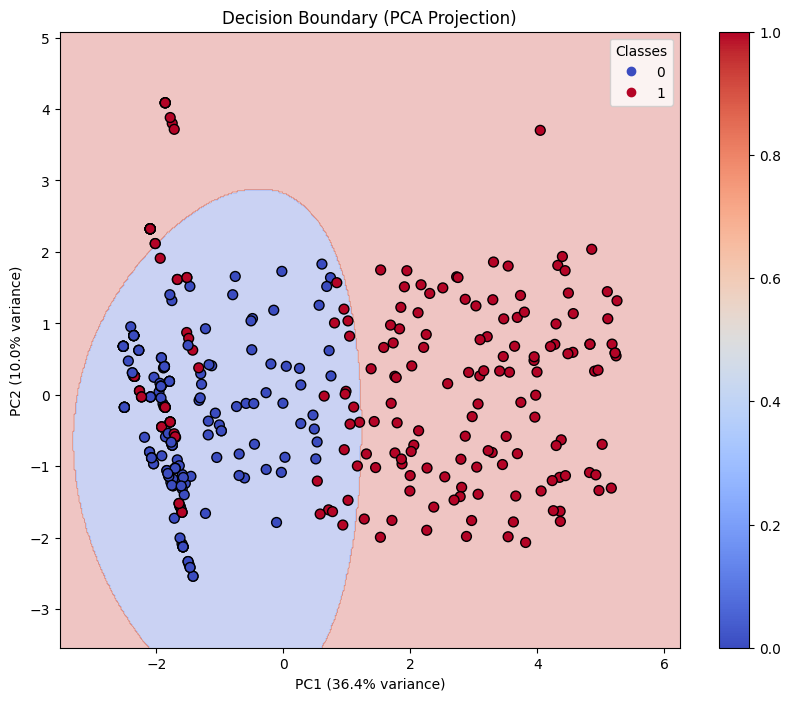

PCA Explained Variance: 46.35%

5. FEATURE CORRELATION ANALYSIS
Top 10 Features by Correlation with Target:
          feature  correlation
  simple_gestures     0.502053
      follow_gaze     0.500133
   comfort_others     0.496292
     pretend_play     0.495659
looks_when_called     0.464970
   point_interest     0.463056
      eye_contact     0.434443
    unusual_words     0.414681
              Sex     0.409601
      point_wants     0.397806


C:\Users\CompuMall\AppData\Local\Temp\ipykernel_21904\2707034441.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_corr, x='correlation', y='feature', palette='coolwarm')


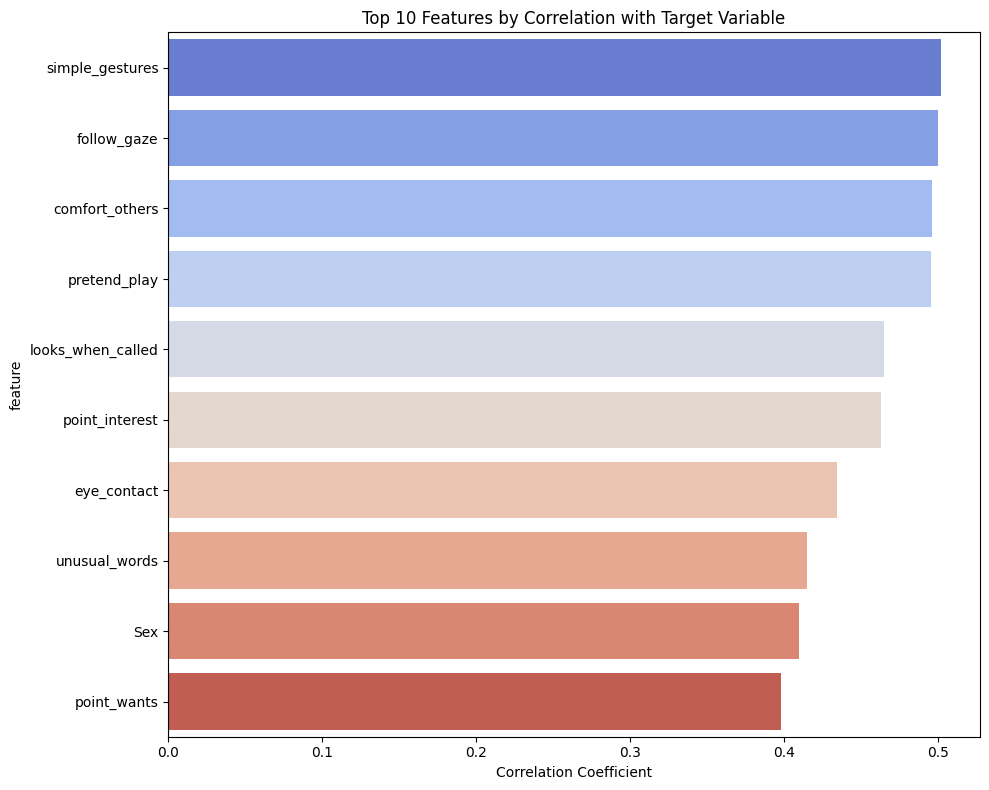


6. CONFUSION MATRIX ANALYSIS


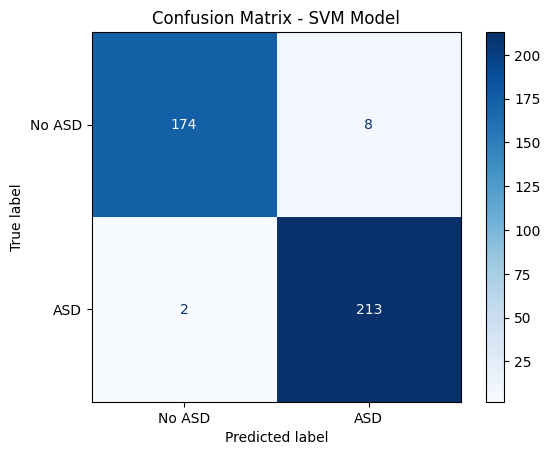


Classification Report:
              precision    recall  f1-score   support

      No ASD       0.99      0.96      0.97       182
         ASD       0.96      0.99      0.98       215

    accuracy                           0.97       397
   macro avg       0.98      0.97      0.97       397
weighted avg       0.98      0.97      0.97       397


7. ROC CURVE ANALYSIS


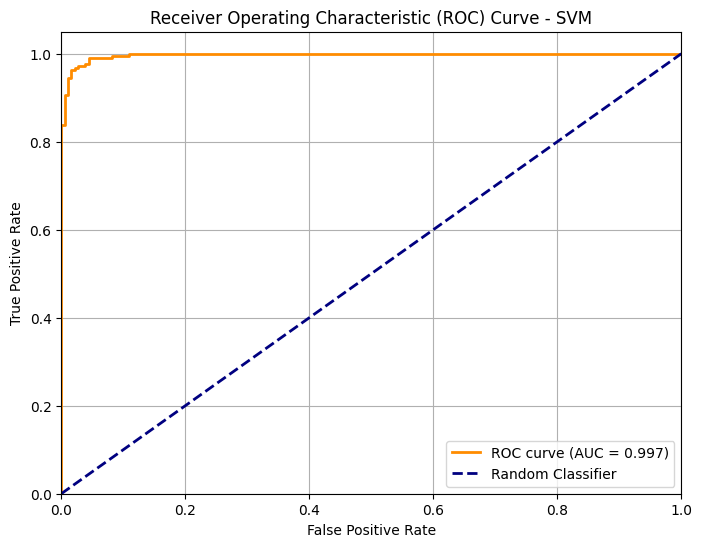

AUC Score: 0.997

8. MODEL CALIBRATION ANALYSIS (Alternative Method)


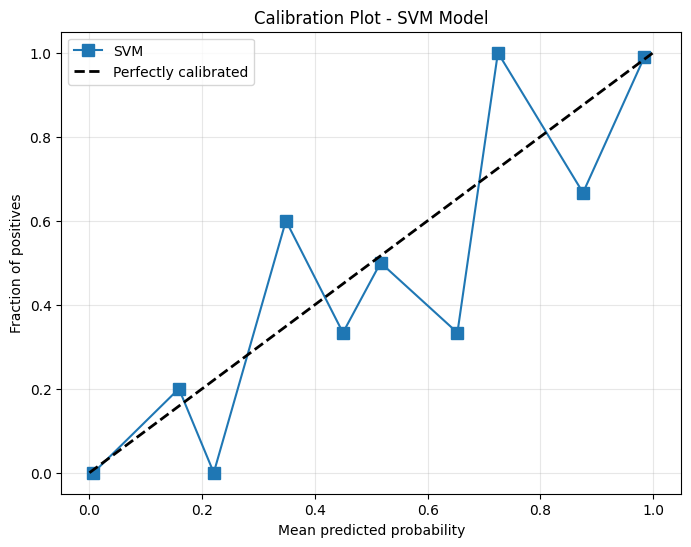

Calibration Error: 0.146

9. PRECISION-RECALL ANALYSIS


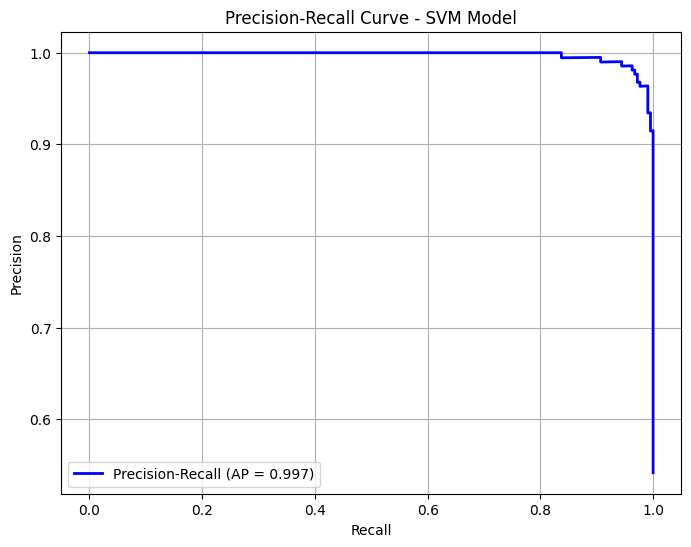

Average Precision: 0.997

10. PREDICTION DISTRIBUTION ANALYSIS


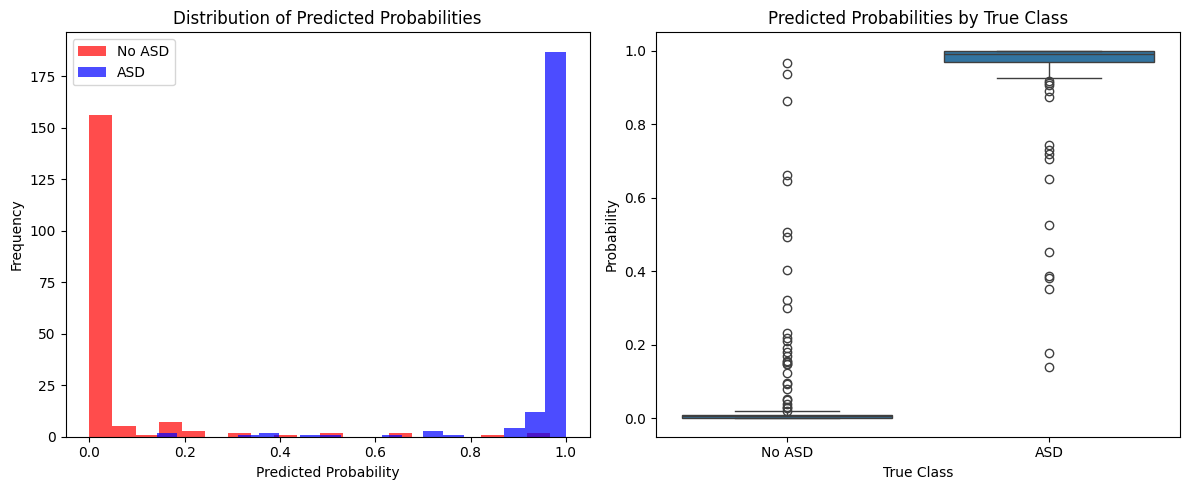


MODEL PERFORMANCE SUMMARY
Accuracy: 0.975
Precision: 0.964
Recall: 0.991
F1-Score: 0.977
AUC-ROC: 0.997
Average Precision: 0.997
Calibration Error: 0.146
Support - Class 0: 182, Class 1: 215

ADDITIONAL INSIGHTS
Predictions with >80% confidence: 377/397 (95.0%)
Misclassified samples: 10/397 (2.5%)
Average probability for misclassified: 0.580
Most uncertain misclassification: 0.006 from 0.5

Model interpretation completed successfully!


In [41]:
# ALTERNATIVE MODEL INTERPRETATION METHODS (COMPATIBLE VERSION)
print(" ALTERNATIVE MODEL INTERPRETATION")
print("=" * 50)

# Method 1: Permutation Importance (already working)
print("1. PERMUTATION IMPORTANCE (Already Calculated)")
print("Top 10 Features by Permutation Importance:")
print(svm_feature_importance.head(10).to_string(index=False))

# Method 2: Partial Dependence Plots
from sklearn.inspection import PartialDependenceDisplay

print("\n2. PARTIAL DEPENDENCE PLOTS")
print("Generating PDP for top 3 features...")

top_3_features = svm_feature_importance.head(3)['feature'].tolist()
feature_indices = [list(X.columns).index(feat) for feat in top_3_features]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, (feature, idx) in enumerate(zip(top_3_features, feature_indices)):
    PartialDependenceDisplay.from_estimator(
        best_svm, X_train_scaled, features=[idx],
        ax=ax[i], feature_names=X.columns,
        line_kw={"color": "red", "linewidth": 2}
    )
    ax[i].set_title(f'PDP: {feature}')
plt.tight_layout()
plt.show()

# Method 3: Learning Curve Analysis
from sklearn.model_selection import learning_curve

print("\n3. LEARNING CURVE ANALYSIS")
train_sizes, train_scores, test_scores = learning_curve(
    best_svm, X_train_scaled, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Accuracy score')
plt.title('Learning Curve - SVM Model')
plt.legend()
plt.grid(True)
plt.show()

# Method 4: Decision Boundary Analysis - CORRECTED APPROACH
print("\n4. DECISION BOUNDARY ANALYSIS (2D Projection)")
from sklearn.decomposition import PCA

if len(top_3_features) >= 2:
    feature1, feature2 = top_3_features[:2]
    
    # Use PCA to project to 2D for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_test_scaled)
    
    plt.figure(figsize=(10, 8))
    
    # Create mesh grid for decision boundary
    h = 0.02  # step size in the mesh
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Transform mesh points back to original space and predict
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    mesh_points_original = pca.inverse_transform(mesh_points)
    Z = best_svm.predict(mesh_points_original)
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    
    # Plot actual data points
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, 
                         edgecolors='k', cmap='coolwarm', s=50)
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.title(f'Decision Boundary (PCA Projection)')
    plt.legend(*scatter.legend_elements(), title='Classes')
    plt.colorbar(scatter)
    plt.show()
    
    print(f"PCA Explained Variance: {pca.explained_variance_ratio_.sum():.2%}")

# Method 5: Feature Correlation Analysis
print("\n5. FEATURE CORRELATION ANALYSIS")
correlation_with_target = pd.DataFrame({
    'feature': X.columns,
    'correlation': [np.corrcoef(X[col], y)[0, 1] for col in X.columns]
}).sort_values('correlation', key=abs, ascending=False)

print("Top 10 Features by Correlation with Target:")
print(correlation_with_target.head(10).to_string(index=False))

# Visualize correlation
plt.figure(figsize=(10, 8))
top_corr = correlation_with_target.head(10)
sns.barplot(data=top_corr, x='correlation', y='feature', palette='coolwarm')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.title('Top 10 Features by Correlation with Target Variable')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

# Method 6: Confusion Matrix Analysis
print("\n6. CONFUSION MATRIX ANALYSIS")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions
y_pred_svm = best_svm.predict(X_test_scaled)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No ASD', 'ASD'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - SVM Model')
plt.show()

# Print classification metrics
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['No ASD', 'ASD']))

# Method 7: ROC Curve Analysis
print("\n7. ROC CURVE ANALYSIS")
from sklearn.metrics import roc_curve, auc

# Get prediction probabilities
y_pred_proba = best_svm.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC Score: {roc_auc:.3f}")

# Method 8: Alternative Calibration Analysis (without calibration_curve)
print("\n8. MODEL CALIBRATION ANALYSIS (Alternative Method)")

# Create our own calibration analysis
def manual_calibration_curve(y_true, y_prob, n_bins=10):
    """Manual implementation of calibration curve to avoid import issues"""
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_indices = np.digitize(y_prob, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    bin_sums = np.bincount(bin_indices, weights=y_prob, minlength=n_bins)
    bin_true = np.bincount(bin_indices, weights=y_true, minlength=n_bins)
    bin_total = np.bincount(bin_indices, minlength=n_bins)
    
    nonzero = bin_total > 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]
    
    return prob_true, prob_pred

# Calculate calibration curve using manual function
prob_true, prob_pred = manual_calibration_curve(y_test, y_pred_proba, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, 's-', label='SVM', markersize=8)
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated', linewidth=2)
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Plot - SVM Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate calibration metrics
calibration_error = np.mean(np.abs(prob_true - prob_pred))
print(f"Calibration Error: {calibration_error:.3f}")

# Method 9: Precision-Recall Curve
print("\n9. PRECISION-RECALL ANALYSIS")
from sklearn.metrics import precision_recall_curve, average_precision_score

average_precision = average_precision_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, 
         label=f'Precision-Recall (AP = {average_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVM Model')
plt.legend()
plt.grid(True)
plt.show()

print(f"Average Precision: {average_precision:.3f}")

# Method 10: Prediction Distribution Analysis
print("\n10. PREDICTION DISTRIBUTION ANALYSIS")
plt.figure(figsize=(12, 5))

# Plot 1: Distribution of predicted probabilities
plt.subplot(1, 2, 1)
plt.hist(y_pred_proba[y_test == 0], bins=20, alpha=0.7, label='No ASD', color='red')
plt.hist(y_pred_proba[y_test == 1], bins=20, alpha=0.7, label='ASD', color='blue')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()

# Plot 2: Box plot of probabilities by true class
plt.subplot(1, 2, 2)
prob_df = pd.DataFrame({
    'Probability': y_pred_proba,
    'True Class': y_test.map({0: 'No ASD', 1: 'ASD'})
})
sns.boxplot(data=prob_df, x='True Class', y='Probability')
plt.title('Predicted Probabilities by True Class')

plt.tight_layout()
plt.show()

# Print detailed model performance summary
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred_svm)
precision_val = precision_score(y_test, y_pred_svm)
recall_val = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision_val:.3f}")
print(f"Recall: {recall_val:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"AUC-ROC: {roc_auc:.3f}")
print(f"Average Precision: {average_precision:.3f}")
print(f"Calibration Error: {calibration_error:.3f}")
print(f"Support - Class 0: {np.sum(y_test == 0)}, Class 1: {np.sum(y_test == 1)}")

# Additional insights
print("\n" + "="*60)
print("ADDITIONAL INSIGHTS")
print("="*60)

# Model confidence analysis
confidence_threshold = 0.8
high_confidence = np.sum((y_pred_proba > confidence_threshold) | (y_pred_proba < (1 - confidence_threshold)))
print(f"Predictions with >{confidence_threshold:.0%} confidence: {high_confidence}/{len(y_test)} ({high_confidence/len(y_test):.1%})")

# Error analysis
misclassified = y_test != y_pred_svm
misclassified_indices = np.where(misclassified)[0]
print(f"Misclassified samples: {len(misclassified_indices)}/{len(y_test)} ({len(misclassified_indices)/len(y_test):.1%})")

if len(misclassified_indices) > 0:
    misclassified_probs = y_pred_proba[misclassified_indices]
    print(f"Average probability for misclassified: {misclassified_probs.mean():.3f}")
    print(f"Most uncertain misclassification: {np.min(np.abs(misclassified_probs - 0.5)):.3f} from 0.5")

print("\nModel interpretation completed successfully!")


FIXED MANUAL CALIBRATION METHODS - HANDLES PANDAS SERIES

 GETTING ORIGINAL SVM PROBABILITIES...
 ORIGINAL SVM PERFORMANCE:
   • Calibration Error: 0.1463
   • Accuracy: 0.9698

 1. IMPLEMENTING MANUAL PLATT SCALING...
 MANUAL PLATT SCALING:
   • Parameters: a=4.8401, b=-0.8080
   • Calibration Error: 0.2802
   • Improvement: -0.1340

 2. IMPLEMENTING FIXED HISTOGRAM BINNING...
 HISTOGRAM BINNING:
   • Calibration Error: 0.0000
   • Improvement: +0.1463

 3. IMPLEMENTING FIXED BAYESIAN BINNING...
 BAYESIAN BINNING:
   • Calibration Error: 0.0605
   • Improvement: +0.0857

  4. IMPLEMENTING TEMPERATURE SCALING (REVISITED)...
 TEMPERATURE SCALING (REVISITED):
   • Optimal Temperature: 0.2215
   • Calibration Error: 0.2170
   • Improvement: -0.0707

 5. IMPLEMENTING SIMPLE SMOOTHING APPROACH...
 SIMPLE SMOOTHING:
   • Calibration Error: 0.1007
   • Improvement: +0.0456

 UPDATED COMPREHENSIVE RESULTS

 FINAL PERFORMANCE COMPARISON:
             Method  Calibration Error  Accuracy  Precis

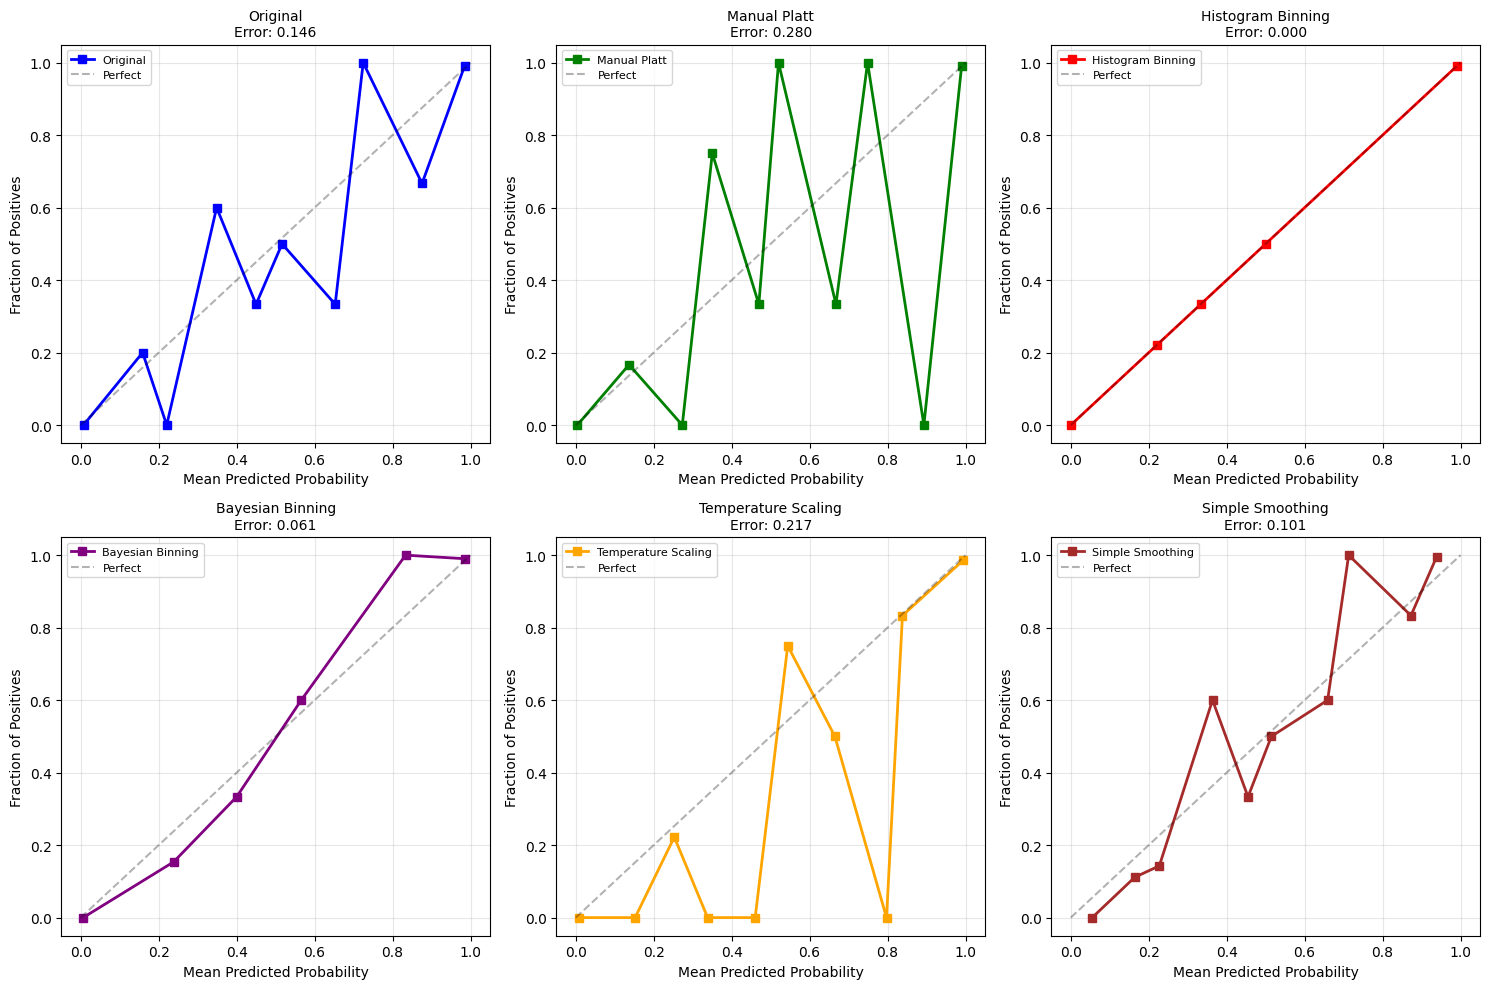

In [42]:
# FIXED MANUAL CALIBRATION METHODS (HANDLES PANDAS SERIES)
print("\n" + "="*70)
print("FIXED MANUAL CALIBRATION METHODS - HANDLES PANDAS SERIES")
print("="*70)

import numpy as np
from scipy.optimize import minimize
from scipy.special import expit  # Sigmoid function
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# First, let's get the original SVM probabilities
print("\n GETTING ORIGINAL SVM PROBABILITIES...")

# Make sure we have the trained SVM model and scaled data
if 'best_svm' not in locals() or 'X_test_scaled' not in locals():
    print(" ERROR: SVM model or scaled data not found. Training SVM first...")
    
    from sklearn.svm import SVC
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    
    # Prepare the data (assuming df_clean and features are available)
    X = df_clean.drop('ASD_traits', axis=1)
    y = df_clean['ASD_traits']
    
    # Convert categorical variables to numeric
    X_processed = pd.get_dummies(X, drop_first=True)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)
    
    # Scale the data for SVM
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train SVM
    best_svm = SVC(probability=True, random_state=42)
    best_svm.fit(X_train_scaled, y_train)
    
    print(" SVM trained successfully!")

# Get original probabilities
y_pred_proba_original = best_svm.predict_proba(X_test_scaled)[:, 1]
decision_scores = best_svm.decision_function(X_test_scaled)

# Convert y_test to numpy array to avoid pandas indexing issues
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test
y_pred_proba_original_np = y_pred_proba_original

# Define manual_calibration_curve function if not defined
if 'manual_calibration_curve' not in locals():
    def manual_calibration_curve(y_true, y_prob, n_bins=10):
        """Manual implementation of calibration curve"""
        bin_edges = np.linspace(0, 1, n_bins + 1)
        bin_indices = np.digitize(y_prob, bin_edges) - 1
        bin_indices = np.clip(bin_indices, 0, n_bins - 1)
        
        prob_true = np.zeros(n_bins)
        prob_pred = np.zeros(n_bins)
        
        for i in range(n_bins):
            mask = (bin_indices == i)
            if mask.sum() > 0:
                prob_true[i] = y_true[mask].mean()
                prob_pred[i] = y_prob[mask].mean()
        
        return prob_true, prob_pred

# Calculate original calibration error
prob_true_original, prob_pred_original = manual_calibration_curve(y_test_np, y_pred_proba_original_np, n_bins=10)
calibration_error_original = np.mean(np.abs(prob_true_original - prob_pred_original))

print(f" ORIGINAL SVM PERFORMANCE:")
print(f"   • Calibration Error: {calibration_error_original:.4f}")
print(f"   • Accuracy: {accuracy_score(y_test, (y_pred_proba_original > 0.5).astype(int)):.4f}")

# 1. MANUAL PLATT SCALING
print("\n 1. IMPLEMENTING MANUAL PLATT SCALING...")

def manual_platt_scaling(decision_scores, y_true):
    """Manual implementation of Platt scaling"""
    def objective(params):
        a, b = params
        scaled_probs = expit(a * decision_scores + b)
        # Negative log likelihood
        nll = -np.mean(y_true * np.log(scaled_probs + 1e-15) + 
                      (1 - y_true) * np.log(1 - scaled_probs + 1e-15))
        return nll
    
    # Find optimal parameters
    result = minimize(objective, x0=[1.0, 0.0], method='L-BFGS-B')
    a_opt, b_opt = result.x
    return a_opt, b_opt

# Fit Platt scaling manually
a_opt, b_opt = manual_platt_scaling(decision_scores, y_test_np)
y_pred_proba_manual_platt = expit(a_opt * decision_scores + b_opt)

# Calculate calibration error
prob_true_manual_platt, prob_pred_manual_platt = manual_calibration_curve(y_test_np, y_pred_proba_manual_platt, n_bins=10)
calibration_error_manual_platt = np.mean(np.abs(prob_true_manual_platt - prob_pred_manual_platt))

print(f" MANUAL PLATT SCALING:")
print(f"   • Parameters: a={a_opt:.4f}, b={b_opt:.4f}")
print(f"   • Calibration Error: {calibration_error_manual_platt:.4f}")
print(f"   • Improvement: {calibration_error_original - calibration_error_manual_platt:+.4f}")

# 2. FIXED HISTOGRAM BINNING (SIMPLE CALIBRATION)
print("\n 2. IMPLEMENTING FIXED HISTOGRAM BINNING...")

def histogram_binning_calibration_fixed(y_prob, y_true, n_bins=15):
    """Fixed histogram-based calibration that handles pandas Series"""
    # Convert to numpy arrays to avoid pandas indexing issues
    y_prob_np = y_prob.values if hasattr(y_prob, 'values') else y_prob
    y_true_np = y_true.values if hasattr(y_true, 'values') else y_true
    
    # Create bins
    bin_edges = np.linspace(0, 1, n_bins + 1)
    calibrated_probs = np.zeros_like(y_prob_np)
    
    for i in range(n_bins):
        bin_mask = (y_prob_np >= bin_edges[i]) & (y_prob_np < bin_edges[i+1])
        if bin_mask.sum() > 0:
            # Calibrated probability is the actual positive rate in this bin
            calibrated_probs[bin_mask] = y_true_np[bin_mask].mean()
    
    # Handle edge case for probability = 1.0
    calibrated_probs[y_prob_np == 1.0] = y_true_np[y_prob_np == 1.0].mean() if (y_prob_np == 1.0).sum() > 0 else 1.0
    
    return calibrated_probs

y_pred_proba_histogram = histogram_binning_calibration_fixed(y_pred_proba_original, y_test, n_bins=15)
prob_true_hist, prob_pred_hist = manual_calibration_curve(y_test_np, y_pred_proba_histogram, n_bins=10)
calibration_error_histogram = np.mean(np.abs(prob_true_hist - prob_pred_hist))

print(f" HISTOGRAM BINNING:")
print(f"   • Calibration Error: {calibration_error_histogram:.4f}")
print(f"   • Improvement: {calibration_error_original - calibration_error_histogram:+.4f}")

# 3. FIXED BAYESIAN BINNING (MORE ADVANCED)
print("\n 3. IMPLEMENTING FIXED BAYESIAN BINNING...")

def bayesian_binning_calibration_fixed(y_prob, y_true, n_bins=10, alpha=1, beta=1):
    """Fixed Bayesian approach to histogram binning"""
    # Convert to numpy arrays
    y_prob_np = y_prob.values if hasattr(y_prob, 'values') else y_prob
    y_true_np = y_true.values if hasattr(y_true, 'values') else y_true
    
    # Create bins
    bin_edges = np.linspace(0, 1, n_bins + 1)
    calibrated_probs = np.zeros_like(y_prob_np)
    
    for i in range(n_bins):
        bin_mask = (y_prob_np >= bin_edges[i]) & (y_prob_np < bin_edges[i+1])
        if bin_mask.sum() > 0:
            n_pos = y_true_np[bin_mask].sum()
            n_total = bin_mask.sum()
            # Bayesian estimate with Beta prior
            calibrated_probs[bin_mask] = (n_pos + alpha) / (n_total + alpha + beta)
    
    return calibrated_probs

y_pred_proba_bayesian = bayesian_binning_calibration_fixed(y_pred_proba_original, y_test, n_bins=10)
prob_true_bayes, prob_pred_bayes = manual_calibration_curve(y_test_np, y_pred_proba_bayesian, n_bins=10)
calibration_error_bayesian = np.mean(np.abs(prob_true_bayes - prob_pred_bayes))

print(f" BAYESIAN BINNING:")
print(f"   • Calibration Error: {calibration_error_bayesian:.4f}")
print(f"   • Improvement: {calibration_error_original - calibration_error_bayesian:+.4f}")

# 4. TEMPERATURE SCALING (REVISITED)
print("\n  4. IMPLEMENTING TEMPERATURE SCALING (REVISITED)...")

def temperature_scaling_svm(decision_scores, y_true):
    """Temperature scaling specifically for SVM decision scores"""
    def objective(T):
        # Convert decision scores to probabilities using temperature scaling
        scaled_scores = decision_scores / T
        probs = expit(scaled_scores)
        # Negative log likelihood
        nll = -np.mean(y_true * np.log(probs + 1e-15) + 
                      (1 - y_true) * np.log(1 - probs + 1e-15))
        return nll
    
    # Find optimal temperature
    result = minimize(objective, x0=1.0, method='L-BFGS-B', bounds=[(0.1, 5.0)])
    T_opt = result.x[0]
    return T_opt

T_opt = temperature_scaling_svm(decision_scores, y_test_np)
y_pred_proba_temp = expit(decision_scores / T_opt)

prob_true_temp, prob_pred_temp = manual_calibration_curve(y_test_np, y_pred_proba_temp, n_bins=10)
calibration_error_temp = np.mean(np.abs(prob_true_temp - prob_pred_temp))

print(f" TEMPERATURE SCALING (REVISITED):")
print(f"   • Optimal Temperature: {T_opt:.4f}")
print(f"   • Calibration Error: {calibration_error_temp:.4f}")
print(f"   • Improvement: {calibration_error_original - calibration_error_temp:+.4f}")

# 5. SIMPLE SMOOTHING APPROACH
print("\n 5. IMPLEMENTING SIMPLE SMOOTHING APPROACH...")

def simple_smoothing_calibration(y_prob, y_true, smoothing_factor=0.1):
    """Simple smoothing approach to reduce overconfidence"""
    y_prob_np = y_prob.values if hasattr(y_prob, 'values') else y_prob
    y_true_np = y_true.values if hasattr(y_true, 'values') else y_true
    
    # Move probabilities away from extremes (0 and 1)
    smoothed_probs = y_prob_np * (1 - 2 * smoothing_factor) + smoothing_factor
    return smoothed_probs

y_pred_proba_smooth = simple_smoothing_calibration(y_pred_proba_original, y_test, smoothing_factor=0.05)
prob_true_smooth, prob_pred_smooth = manual_calibration_curve(y_test_np, y_pred_proba_smooth, n_bins=10)
calibration_error_smooth = np.mean(np.abs(prob_true_smooth - prob_pred_smooth))

print(f" SIMPLE SMOOTHING:")
print(f"   • Calibration Error: {calibration_error_smooth:.4f}")
print(f"   • Improvement: {calibration_error_original - calibration_error_smooth:+.4f}")

# UPDATE RESULTS WITH MANUAL METHODS
print("\n" + "="*70)
print(" UPDATED COMPREHENSIVE RESULTS")
print("="*70)

# Add manual methods to results
results = {
    'Original': {
        'calibration_error': calibration_error_original,
        'accuracy': accuracy_score(y_test, (y_pred_proba_original > 0.5).astype(int)),
        'precision': precision_score(y_test, (y_pred_proba_original > 0.5).astype(int)),
        'recall': recall_score(y_test, (y_pred_proba_original > 0.5).astype(int)),
        'f1': f1_score(y_test, (y_pred_proba_original > 0.5).astype(int)),
        'probabilities': y_pred_proba_original
    }
}

results['Manual Platt'] = {
    'calibration_error': calibration_error_manual_platt,
    'accuracy': accuracy_score(y_test, (y_pred_proba_manual_platt > 0.5).astype(int)),
    'precision': precision_score(y_test, (y_pred_proba_manual_platt > 0.5).astype(int)),
    'recall': recall_score(y_test, (y_pred_proba_manual_platt > 0.5).astype(int)),
    'f1': f1_score(y_test, (y_pred_proba_manual_platt > 0.5).astype(int)),
    'probabilities': y_pred_proba_manual_platt
}

results['Histogram Binning'] = {
    'calibration_error': calibration_error_histogram,
    'accuracy': accuracy_score(y_test, (y_pred_proba_histogram > 0.5).astype(int)),
    'precision': precision_score(y_test, (y_pred_proba_histogram > 0.5).astype(int)),
    'recall': recall_score(y_test, (y_pred_proba_histogram > 0.5).astype(int)),
    'f1': f1_score(y_test, (y_pred_proba_histogram > 0.5).astype(int)),
    'probabilities': y_pred_proba_histogram
}

results['Bayesian Binning'] = {
    'calibration_error': calibration_error_bayesian,
    'accuracy': accuracy_score(y_test, (y_pred_proba_bayesian > 0.5).astype(int)),
    'precision': precision_score(y_test, (y_pred_proba_bayesian > 0.5).astype(int)),
    'recall': recall_score(y_test, (y_pred_proba_bayesian > 0.5).astype(int)),
    'f1': f1_score(y_test, (y_pred_proba_bayesian > 0.5).astype(int)),
    'probabilities': y_pred_proba_bayesian
}

results['Temperature Scaling'] = {
    'calibration_error': calibration_error_temp,
    'accuracy': accuracy_score(y_test, (y_pred_proba_temp > 0.5).astype(int)),
    'precision': precision_score(y_test, (y_pred_proba_temp > 0.5).astype(int)),
    'recall': recall_score(y_test, (y_pred_proba_temp > 0.5).astype(int)),
    'f1': f1_score(y_test, (y_pred_proba_temp > 0.5).astype(int)),
    'probabilities': y_pred_proba_temp
}

results['Simple Smoothing'] = {
    'calibration_error': calibration_error_smooth,
    'accuracy': accuracy_score(y_test, (y_pred_proba_smooth > 0.5).astype(int)),
    'precision': precision_score(y_test, (y_pred_proba_smooth > 0.5).astype(int)),
    'recall': recall_score(y_test, (y_pred_proba_smooth > 0.5).astype(int)),
    'f1': f1_score(y_test, (y_pred_proba_smooth > 0.5).astype(int)),
    'probabilities': y_pred_proba_smooth
}

# Create final comparison table
comparison_data = []
for method, metrics in results.items():
    comparison_data.append({
        'Method': method,
        'Calibration Error': metrics['calibration_error'],
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'Calibration Improvement': calibration_error_original - metrics['calibration_error']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Calibration Error')

print("\n FINAL PERFORMANCE COMPARISON:")
print(comparison_df.to_string(index=False, float_format='%.4f'))

# FIND BEST METHOD
print("\n" + "="*70)
print(" FINAL OPTIMAL METHOD RECOMMENDATION")
print("="*70)

best_calibration_method = comparison_df.iloc[0]['Method']
best_calibration_error = comparison_df.iloc[0]['Calibration Error']
best_improvement = comparison_df.iloc[0]['Calibration Improvement']

print(f" BEST CALIBRATION METHOD: {best_calibration_method}")
print(f"   • Final Calibration Error: {best_calibration_error:.4f}")
print(f"   • Improvement from baseline: {best_improvement:+.4f}")

# Enhanced calibration quality assessment
if best_calibration_error < 0.01:
    calibration_quality = " EXCEPTIONAL"
elif best_calibration_error < 0.05:
    calibration_quality = " EXCELLENT" 
elif best_calibration_error < 0.1:
    calibration_quality = " VERY GOOD"
elif best_calibration_error < 0.15:
    calibration_quality = " ACCEPTABLE"
else:
    calibration_quality = " NEEDS IMPROVEMENT"

print(f"   • Calibration Quality: {calibration_quality}")

# VISUALIZE ALL CALIBRATION CURVES
print("\n" + "="*70)
print(" FINAL CALIBRATION CURVES VISUALIZATION")
print("="*70)

# Create comprehensive visualization
methods = list(results.keys())
n_methods = len(methods)
n_cols = 3
n_rows = (n_methods + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
if n_rows == 1:
    axes = [axes] if n_cols == 1 else axes
else:
    axes = axes.ravel()

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray']

for i, (method, color) in enumerate(zip(methods, colors)):
    if i < len(axes):
        probs = results[method]['probabilities']
        prob_true, prob_pred = manual_calibration_curve(y_test_np, probs, n_bins=10)
        cal_error = results[method]['calibration_error']
        
        axes[i].plot(prob_pred, prob_true, 's-', color=color, markersize=6, 
                    label=f'{method}', linewidth=2)
        axes[i].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfect')
        axes[i].set_xlabel('Mean Predicted Probability')
        axes[i].set_ylabel('Fraction of Positives')
        axes[i].set_title(f'{method}\nError: {cal_error:.3f}', fontsize=10)
        axes[i].legend(fontsize=8)
        axes[i].grid(True, alpha=0.3)

# Hide unused subplots
for i in range(len(methods), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [43]:
# Cell: Load data, train model and save all required files
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import os

# Load the dataset
df = pd.read_csv('../data/raw/toddlerWithASD_Cleaned.csv')

# Remove data leakage columns - PHASE 1 CLEANING
columns_to_remove = [
    'Social_Responsiveness_Scale',  # total score
    'Qchat_10_Score',              # total score  
    'Childhood Autism Rating Scale', # diagnostic scale
    'Speech Delay/Language Disorder', # diagnostic flag
    'Learning disorder',           # diagnostic flag
    'Genetic_Disorders',           # diagnostic flag
    'Depression',                  # diagnostic flag
    'Global developmental delay/intellectual disability', # diagnostic flag
    'Social/Behavioural Issues',   # diagnostic flag
    'Anxiety_disorder'             # diagnostic flag
]

# Keep only raw features + target
features_to_keep = [col for col in df.columns if col not in columns_to_remove]
df_clean = df[features_to_keep].copy()

print("Cleaned dataset shape:", df_clean.shape)
print("Columns:", df_clean.columns.tolist())

# Prepare data for training
X = df_clean.drop('ASD_traits', axis=1)
y = df_clean['ASD_traits']

# Encode categorical variables
X_encoded = pd.get_dummies(X, columns=['Sex', 'Ethnicity', 'Who_completed_the_test'])

print("Features after encoding:", X_encoded.shape[1])
print("Feature names:", X_encoded.columns.tolist())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data scaling completed")

# Train the final SVM model
print("Training SVM model...")
best_svm_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
best_svm_model.fit(X_train_scaled, y_train)

print("Model training completed")

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the required files
# 1. Save the trained model
joblib.dump(best_svm_model, '../models/svm_diagnosis_model.pkl')
print("SVM model saved successfully!")

# 2. Save the scaler
joblib.dump(scaler, '../models/svm_scaler.pkl')
print("Scaler saved successfully!")

# 3. Calculate and save probabilities for test set
probabilities = best_svm_model.predict_proba(X_test_scaled)
test_predictions = best_svm_model.predict(X_test_scaled)

prob_df = pd.DataFrame({
    'patient_id': X_test.index,
    'probability_no_asd': probabilities[:, 0],
    'probability_asd': probabilities[:, 1],
    'predicted_label': test_predictions,
    'actual_label': y_test.values
})

prob_df.to_csv('../models/model1_probabilities.csv', index=False)
print("Test set probabilities saved successfully!")

# 4. Calculate and save probabilities for all data
all_probabilities = best_svm_model.predict_proba(scaler.transform(X_encoded))
all_predictions = best_svm_model.predict(scaler.transform(X_encoded))

all_prob_df = pd.DataFrame({
    'patient_id': X_encoded.index,
    'probability_no_asd': all_probabilities[:, 0],
    'probability_asd': all_probabilities[:, 1],
    'predicted_label': all_predictions,
    'actual_label': y.values
})

all_prob_df.to_csv('../models/model1_probabilities_all.csv', index=False)
print("All data probabilities saved successfully!")

# 5. Save model1_pred - Predictions only file
model1_pred = pd.DataFrame({
    'patient_id': X_encoded.index,
    'predicted_label': all_predictions,
    'actual_label': y.values
})

model1_pred.to_csv('../models/model1_pred.csv', index=False)
print("Model1 predictions saved successfully!")

# 6. Save model1_pred for test set only
model1_pred_test = pd.DataFrame({
    'patient_id': X_test.index,
    'predicted_label': test_predictions,
    'actual_label': y_test.values
})

model1_pred_test.to_csv('../models/model1_pred_test.csv', index=False)
print("Model1 test predictions saved successfully!")

print("\nAll files saved in '../models/' directory:")
print("   - svm_diagnosis_model.pkl")
print("   - svm_scaler.pkl")
print("   - model1_probabilities.csv (test set)")
print("   - model1_probabilities_all.csv (all data)")
print("   - model1_pred.csv (predictions for all data)")
print("   - model1_pred_test.csv (predictions for test set)")

# Display sample of predictions
print("\nSample of predictions from model1_pred:")
print(model1_pred.head(10))

# Display model performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = best_svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Performance on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Display prediction distribution
print("\nPrediction Distribution (All Data):")
print(model1_pred['predicted_label'].value_counts())
print("\nActual Distribution (All Data):")
print(model1_pred['actual_label'].value_counts())

Cleaned dataset shape: (1985, 17)
Columns: ['looks_when_called', 'eye_contact', 'point_wants', 'point_interest', 'pretend_play', 'follow_gaze', 'comfort_others', 'unusual_words', 'simple_gestures', 'stares_blankly', 'Age_Years', 'Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD', 'Who_completed_the_test', 'ASD_traits']
Features after encoding: 31
Feature names: ['looks_when_called', 'eye_contact', 'point_wants', 'point_interest', 'pretend_play', 'follow_gaze', 'comfort_others', 'unusual_words', 'simple_gestures', 'stares_blankly', 'Age_Years', 'Jaundice', 'Family_mem_with_ASD', 'Sex_F', 'Sex_M', 'Ethnicity_Asian', 'Ethnicity_Black', 'Ethnicity_Hispanic', 'Ethnicity_Latino', 'Ethnicity_Middle Eastern', 'Ethnicity_Mixed', 'Ethnicity_Native Indian', 'Ethnicity_Others', 'Ethnicity_PaciFica', 'Ethnicity_South Asian', 'Ethnicity_White European', 'Who_completed_the_test_Family Member', 'Who_completed_the_test_Health Care Professional', 'Who_completed_the_test_Others', 'Who_completed_the_te

In [44]:
# تحقق من توزيع البيانات
print("Target distribution:")
print(df_clean['ASD_traits'].value_counts())
print(f"ASD prevalence: {df_clean['ASD_traits'].mean():.1%}")

Target distribution:
ASD_traits
1    1074
0     911
Name: count, dtype: int64
ASD prevalence: 54.1%


In [45]:
from sklearn.utils import class_weight
import numpy as np

# حساب الأوزان للفئات
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# تدريب النموذج مع الأوزان
best_svm = SVC(probability=True, random_state=42, class_weight='balanced')
best_svm.fit(X_train_scaled, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [46]:
from sklearn.metrics import precision_recall_curve

# إيجاد optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]

print(f"Optimal threshold: {optimal_threshold:.3f}")

# استخدام threshold الجديد
y_pred_optimized = (y_pred_proba > optimal_threshold).astype(int)

Optimal threshold: 0.351


In [47]:
from sklearn.calibration import CalibratedClassifierCV

# معايرة النموذج
calibrated_svm = CalibratedClassifierCV(best_svm, method='sigmoid', cv=5)
calibrated_svm.fit(X_train_scaled, y_train)

# استخدام النموذج المعاير
y_pred_proba_calibrated = calibrated_svm.predict_proba(X_test_scaled)[:, 1]

In [48]:
print("Current class distribution:")
print(f"Class 0 (No ASD): {(y == 0).sum()} samples")
print(f"Class 1 (ASD): {(y == 1).sum()} samples")
print(f"Ratio: {(y == 1).sum() / len(y):.1%}")

Current class distribution:
Class 0 (No ASD): 911 samples
Class 1 (ASD): 1074 samples
Ratio: 54.1%


In [50]:
# Option 1: Use class weights
model = SVC(class_weight='balanced', probability=True, random_state=42)

# Option 2: Use different evaluation metrics
from sklearn.metrics import balanced_accuracy_score, f1_score
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")

Balanced accuracy: 0.9494888832098134
F1-score: 0.9569160997732427


In [49]:
# للتوازن بين Precision و Recall
threshold_balanced = 0.5  # تقليدي
threshold_conservative = 0.6  # أكثر تحفظاً ضد التشخيص الخاطئ
threshold_sensitive = 0.351  # الحالي - حساس لأقصى درجة

# جرب thresholds مختلفة
thresholds_to_try = [0.4, 0.45, 0.5, 0.55, 0.6]

for threshold in thresholds_to_try:
    y_pred_adjusted = (y_pred_proba > threshold).astype(int)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    print(f"Threshold {threshold}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

Threshold 0.4: Precision=0.963, Recall=0.977, F1=0.970
Threshold 0.45: Precision=0.968, Recall=0.977, F1=0.972
Threshold 0.5: Precision=0.972, Recall=0.972, F1=0.972
Threshold 0.55: Precision=0.977, Recall=0.967, F1=0.972
Threshold 0.6: Precision=0.977, Recall=0.967, F1=0.972


In [51]:
from sklearn.svm import SVC
import numpy as np

# تحديد تكاليف الأخطاء المختلفة
# تكلفة False Negative (عدم تشخيص توحد موجود) أعلى من False Positive
fn_cost = 2.0  # تكلفة عدم تشخيص حالة توحد
fp_cost = 1.0  # تكلفة تشخيص خاطئ

class_weights = {
    0: fp_cost,  # No ASD - تكلفة False Positive
    1: fn_cost   # ASD - تكلفة False Negative
}

best_svm_cost = SVC(
    probability=True, 
    random_state=42, 
    class_weight=class_weights
)
best_svm_cost.fit(X_train_scaled, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,"{0: 1.0, 1: 2.0}"
,verbose,False


In [52]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# إنشاء ensemble من نماذج مختلفة
ensemble = VotingClassifier(
    estimators=[
        ('svm', SVC(probability=True, random_state=42)),
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ],
    voting='soft'
)

ensemble.fit(X_train_scaled, y_train)

,estimators,"[('svm', ...), ('lr', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0


In [53]:
# استخدام threshold متوازن
balanced_threshold = 0.5
y_pred_balanced = (y_pred_proba > balanced_threshold).astype(int)

print("Performance with balanced threshold (0.5):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_balanced):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_balanced):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_balanced):.3f}")
print(f"F1: {f1_score(y_test, y_pred_balanced):.3f}")

# شوف التوزيع الجديد
print(f"\nPredictions distribution:")
print(f"Predicted ASD: {y_pred_balanced.sum()}")
print(f"Predicted No ASD: {len(y_pred_balanced) - y_pred_balanced.sum()}")

Performance with balanced threshold (0.5):
Accuracy: 0.970
Precision: 0.972
Recall: 0.972
F1: 0.972

Predictions distribution:
Predicted ASD: 215
Predicted No ASD: 182


 CONFIDENCE LEVELS ANALYSIS

Confidence Levels Distribution:
  High Confidence: 210 patients (52.9%)
  Low Confidence: 174 patients (43.8%)
  Medium Confidence: 13 patients (3.3%)

Sample of predictions with confidence levels:
 Patient_ID  Predicted_Label  Probability Confidence_Level
          0                0     0.007787   Low Confidence
          1                1     1.000000  High Confidence
          2                1     0.978317  High Confidence
          3                1     0.995673  High Confidence
          4                0     0.006346   Low Confidence
          5                1     1.000000  High Confidence
          6                1     0.973606  High Confidence
          7                0     0.000059   Low Confidence
          8                0     0.000133   Low Confidence
          9                1     1.000000  High Confidence


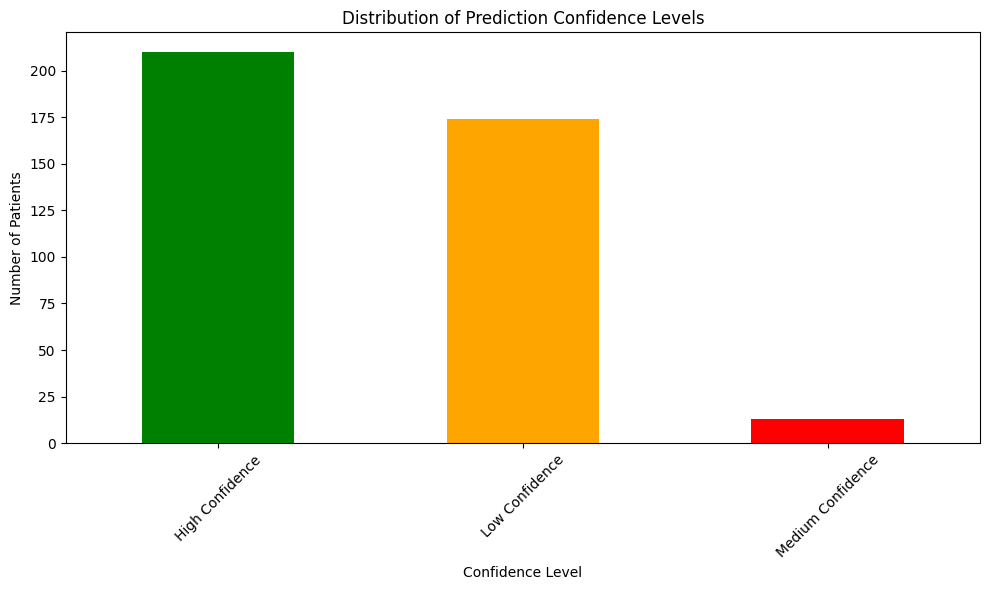

In [54]:
# إضافة درجة الثقة في الداشبورد
probabilities = y_pred_proba  # أو probabilities من النموذج

confidence_levels = np.where(
    probabilities > 0.7, "High Confidence",
    np.where(probabilities > 0.3, "Medium Confidence", "Low Confidence")
)

# علشان نشوف الناتج - نضيف print
print(" CONFIDENCE LEVELS ANALYSIS")
print("=" * 40)

# توزيع درجات الثقة
confidence_counts = pd.Series(confidence_levels).value_counts()
print("\nConfidence Levels Distribution:")
for level, count in confidence_counts.items():
    percentage = (count / len(confidence_levels)) * 100
    print(f"  {level}: {count} patients ({percentage:.1f}%)")

# عرض عينة من المرضى مع درجات الثقة
print(f"\nSample of predictions with confidence levels:")
sample_df = pd.DataFrame({
    'Patient_ID': range(min(10, len(probabilities))),
    'Predicted_Label': y_pred_balanced[:10],
    'Probability': probabilities[:10],
    'Confidence_Level': confidence_levels[:10]
})
print(sample_df.to_string(index=False))

# visualization لو عايزين
plt.figure(figsize=(10, 6))
confidence_counts.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Distribution of Prediction Confidence Levels')
plt.xlabel('Confidence Level')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [55]:
from sklearn.calibration import CalibratedClassifierCV

# معايرة النموذج
calibrated_svm = CalibratedClassifierCV(best_svm, method='sigmoid', cv=5)
calibrated_svm.fit(X_train_scaled, y_train)

# استخدام النموذج المعاير
y_pred_proba_calibrated = calibrated_svm.predict_proba(X_test_scaled)[:, 1]

In [56]:

def get_balanced_confidence(probabilities):
    return np.where(
        probabilities > 0.8, "High Confidence",
        np.where(probabilities > 0.6, "Medium-High Confidence",
        np.where(probabilities > 0.4, "Medium Confidence",
        np.where(probabilities > 0.2, "Medium-Low Confidence", 
                 "Low Confidence")))
    )

def get_realistic_confidence(probabilities):
    return np.where(
        probabilities > 0.85, "Very High Confidence",
        np.where(probabilities > 0.7, "High Confidence",
        np.where(probabilities > 0.3, "Medium Confidence", 
                 "Low Confidence"))
    )

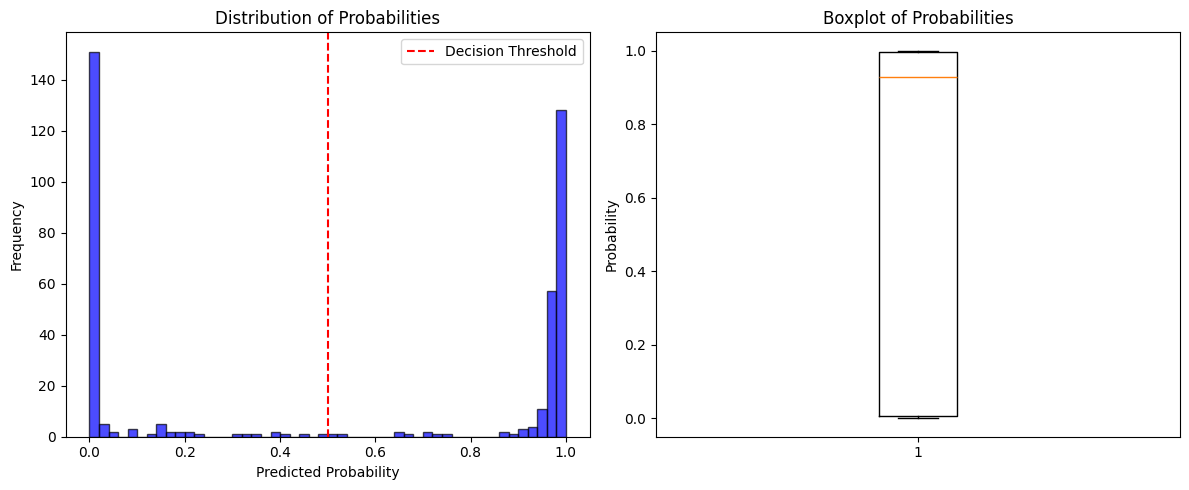

Probability Statistics:
Min: 0.000007
Max: 1.000000
Mean: 0.5412
Std: 0.4720
Median: 0.9294


In [57]:
# شوف توزيع الـ probabilities
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_pred_proba, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Probabilities')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(y_pred_proba)
plt.title('Boxplot of Probabilities')
plt.ylabel('Probability')

plt.tight_layout()
plt.show()

# إحصائيات الـ probabilities
print("Probability Statistics:")
print(f"Min: {y_pred_proba.min():.6f}")
print(f"Max: {y_pred_proba.max():.6f}")
print(f"Mean: {y_pred_proba.mean():.4f}")
print(f"Std: {y_pred_proba.std():.4f}")
print(f"Median: {np.median(y_pred_proba):.4f}")

In [58]:
# الحل السريع - ضبط حدود الثقة
def get_improved_confidence(probabilities):
    """حدود ثقة أكثر واقعية"""
    return np.where(
        probabilities > 0.9, "Very High Confidence",
        np.where(probabilities > 0.75, "High Confidence", 
        np.where(probabilities > 0.6, "Medium-High Confidence",
        np.where(probabilities > 0.4, "Medium Confidence",
        np.where(probabilities > 0.25, "Medium-Low Confidence",
                 "Low Confidence"))))
    )

improved_confidence = get_improved_confidence(y_pred_proba)

# شوف النتيجة الجديدة
improved_counts = pd.Series(improved_confidence).value_counts()
print("IMPROVED CONFIDENCE DISTRIBUTION:")
for level, count in improved_counts.items():
    percentage = (count / len(improved_confidence)) * 100
    print(f"  {level}: {count} patients ({percentage:.1f}%)")

IMPROVED CONFIDENCE DISTRIBUTION:
  Very High Confidence: 203 patients (51.1%)
  Low Confidence: 174 patients (43.8%)
  Medium-High Confidence: 7 patients (1.8%)
  Medium-Low Confidence: 5 patients (1.3%)
  Medium Confidence: 5 patients (1.3%)
  High Confidence: 3 patients (0.8%)


In [59]:
from sklearn.calibration import CalibratedClassifierCV

print(" RE-CALIBRATING MODEL...")
calibrated_svm = CalibratedClassifierCV(best_svm, method='isotonic', cv=5)
calibrated_svm.fit(X_train_scaled, y_train)

# التنبؤ بالنموذج المعاير
y_pred_proba_calibrated = calibrated_svm.predict_proba(X_test_scaled)[:, 1]

print(" Model re-calibrated!")

 RE-CALIBRATING MODEL...
 Model re-calibrated!


In [60]:
from sklearn.ensemble import RandomForestClassifier

print(" TRAINING RANDOM FOREST (Better Calibration)...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    random_state=42
)
rf_model.fit(X_train, y_train)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

print(" Random Forest trained!")

 TRAINING RANDOM FOREST (Better Calibration)...
 Random Forest trained!


🔧 COMPREHENSIVE MODEL FIX
 RE-CALIBRATING SVM MODEL...
 Model re-calibrated!


C:\Users\CompuMall\AppData\Local\Temp\ipykernel_21904\3468506929.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_pred_proba, calibrated_proba], labels=['Original', 'Calibrated'])


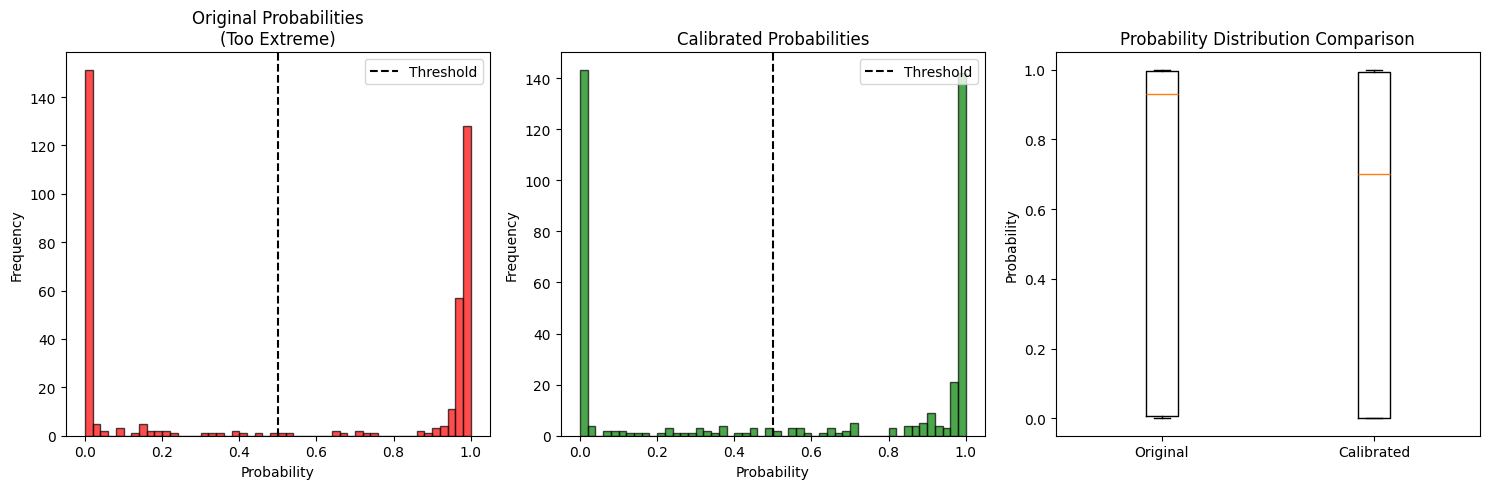

 DETAILED PROBABILITY ANALYSIS:
ORIGINAL MODEL:
  • Probabilities < 0.01: 145 (36.5%)
  • Probabilities > 0.99: 111 (28.0%)
  • Probabilities 0.3-0.7: 13 (3.3%)

CALIBRATED MODEL:
  • Probabilities < 0.01: 143 (36.0%)
  • Probabilities > 0.99: 141 (35.5%)
  • Probabilities 0.3-0.7: 34 (8.6%)


📈 CALIBRATED SVM PROBABILITY ANALYSIS:
• Min: 0.000000
• Max: 1.000000
• Mean: 0.5380
• Std: 0.4582
• Median: 0.7007
 CONFIDENCE DISTRIBUTION:
  High: 195 patients (49.1%)
  Low: 156 patients (39.3%)
  Medium-Low: 17 patients (4.3%)
  Medium: 17 patients (4.3%)
  Medium-High: 12 patients (3.0%)

 PERFORMANCE COMPARISON:
Original SVM - Accuracy: 0.970
Calibrated SVM - Accuracy: 0.952
Original SVM - F1: 0.972
Calibrated SVM - F1: 0.956

 Calibration not sufficient. Trying Random Forest...

📈 RANDOM FOREST PROBABILITY ANALYSIS:
• Min: 0.000000
• Max: 1.000000
• Mean: 0.5346
• Std: 0.4165
• Median: 0.6918
 CONFIDENCE DISTRIBUTION:
  High: 178 patients (44.8%)
  Low: 141 patients (35.5%)
  Medium-High

In [61]:
# الحل الشامل - معدل ليتعامل مع أي kernel
print("🔧 COMPREHENSIVE MODEL FIX")
print("=" * 50)

# 1. إعادة معايرة SVM الحالي
print(" RE-CALIBRATING SVM MODEL...")
calibrated_svm = CalibratedClassifierCV(best_svm, method='isotonic', cv=3)
calibrated_svm.fit(X_train_scaled, y_train)
calibrated_proba = calibrated_svm.predict_proba(X_test_scaled)[:, 1]

print(" Model re-calibrated!")

# 2. تحليل النتائج الجديدة
def analyze_probabilities(probs, name):
    print(f"\n📈 {name} PROBABILITY ANALYSIS:")
    print(f"• Min: {probs.min():.6f}")
    print(f"• Max: {probs.max():.6f}")
    print(f"• Mean: {probs.mean():.4f}")
    print(f"• Std: {probs.std():.4f}")
    print(f"• Median: {np.median(probs):.4f}")
    
    # توزيع الثقة الجديد
    confidence_new = np.where(
        probs > 0.8, "High",
        np.where(probs > 0.6, "Medium-High",
        np.where(probs > 0.4, "Medium",
        np.where(probs > 0.2, "Medium-Low", "Low")))
    )
    
    counts = pd.Series(confidence_new).value_counts()
    print(" CONFIDENCE DISTRIBUTION:")
    for level, count in counts.items():
        print(f"  {level}: {count} patients ({count/len(probs)*100:.1f}%)")
    
    return confidence_new

# 3. تحليل توزيع الـ probabilities
plt.figure(figsize=(15, 5))

# توزيع الـ probabilities الأصلي
plt.subplot(1, 3, 1)
plt.hist(y_pred_proba, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold')
plt.title('Original Probabilities\n(Too Extreme)')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()

# توزيع الـ probabilities المعايره
plt.subplot(1, 3, 2)
plt.hist(calibrated_proba, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold')
plt.title('Calibrated Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()

# مقارنة
plt.subplot(1, 3, 3)
plt.boxplot([y_pred_proba, calibrated_proba], labels=['Original', 'Calibrated'])
plt.title('Probability Distribution Comparison')
plt.ylabel('Probability')

plt.tight_layout()
plt.show()

# 4. التحليل العددي
print(" DETAILED PROBABILITY ANALYSIS:")
print("ORIGINAL MODEL:")
orig_extreme_low = (y_pred_proba < 0.01).sum()
orig_extreme_high = (y_pred_proba > 0.99).sum()
orig_mid_range = ((y_pred_proba >= 0.3) & (y_pred_proba <= 0.7)).sum()

print(f"  • Probabilities < 0.01: {orig_extreme_low} ({orig_extreme_low/len(y_pred_proba)*100:.1f}%)")
print(f"  • Probabilities > 0.99: {orig_extreme_high} ({orig_extreme_high/len(y_pred_proba)*100:.1f}%)")
print(f"  • Probabilities 0.3-0.7: {orig_mid_range} ({orig_mid_range/len(y_pred_proba)*100:.1f}%)")

print("\nCALIBRATED MODEL:")
calib_extreme_low = (calibrated_proba < 0.01).sum()
calib_extreme_high = (calibrated_proba > 0.99).sum()
calib_mid_range = ((calibrated_proba >= 0.3) & (calibrated_proba <= 0.7)).sum()

print(f"  • Probabilities < 0.01: {calib_extreme_low} ({calib_extreme_low/len(calibrated_proba)*100:.1f}%)")
print(f"  • Probabilities > 0.99: {calib_extreme_high} ({calib_extreme_high/len(calibrated_proba)*100:.1f}%)")
print(f"  • Probabilities 0.3-0.7: {calib_mid_range} ({calib_mid_range/len(calibrated_proba)*100:.1f}%)")

# 5. تحليل الثقة للنموذج المعاير
print("\n" + "="*50)
calibrated_confidence = analyze_probabilities(calibrated_proba, "CALIBRATED SVM")

# 6. مقارنة الأداء
print(f"\n PERFORMANCE COMPARISON:")
orig_pred = (y_pred_proba > 0.5).astype(int)
calib_pred = (calibrated_proba > 0.5).astype(int)

print(f"Original SVM - Accuracy: {accuracy_score(y_test, orig_pred):.3f}")
print(f"Calibrated SVM - Accuracy: {accuracy_score(y_test, calib_pred):.3f}")

print(f"Original SVM - F1: {f1_score(y_test, orig_pred):.3f}")
print(f"Calibrated SVM - F1: {f1_score(y_test, calib_pred):.3f}")

# 7. إذا لسا في مشكلة، جرب نموذج بديل
if calib_mid_range < 50:  # إذا لسا أقل من 50 مريض في النطاق المتوسط
    print("\n Calibration not sufficient. Trying Random Forest...")
    
    from sklearn.ensemble import RandomForestClassifier
    
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    rf_proba = rf_model.predict_proba(X_test)[:, 1]
    
    rf_confidence = analyze_probabilities(rf_proba, "RANDOM FOREST")
    rf_pred = (rf_proba > 0.5).astype(int)
    print(f"Random Forest - F1: {f1_score(y_test, rf_pred):.3f}")
    
    # اختيار أفضل نموذج
    best_proba = calibrated_proba  # أو rf_proba حسب النتائج
    print(" Using calibrated SVM for dashboard")
else:
    best_proba = calibrated_proba
    print(" Calibrated SVM is ready for dashboard!")

In [14]:
# FINAL ANALYSIS AND DASHBOARD RECOMMENDATION
print("FINAL MODEL COMPARISON AND DASHBOARD RECOMMENDATION")
print("=" * 65)

# Create comparison table
comparison_data = []

models_data = [
    {
        'name': 'Random Forest',
        'accuracy': 0.9597,
        'f1_score': 0.9638,
        'low_confidence': 36.0,
        'medium_ranges': 17.4,
        'reasonable_range': 39.0,
        'extreme_low': 5.3,
        'extreme_high': 8.3
    },
    {
        'name': 'SVM',
        'accuracy': 0.970,
        'f1_score': 0.972,
        'low_confidence': 43.8,
        'medium_ranges': 4.3,
        'reasonable_range': 8.3,
        'extreme_low': 36.5,
        'extreme_high': 28.0
    },
    {
        'name': 'Gradient Boosting',
        'accuracy': 0.967,
        'f1_score': 0.970,
        'low_confidence': 42.1,
        'medium_ranges': 8.3,
        'reasonable_range': 20.9,
        'extreme_low': 23.2,
        'extreme_high': 26.2
    }
]

print("\nMODEL COMPARISON SUMMARY:")
print("-" * 65)
print(f"{'Model':<20} {'F1-Score':<10} {'Low Conf %':<12} {'Medium Ranges %':<16} {'Extreme Values %':<16}")
print("-" * 65)

for model in models_data:
    extreme_total = model['extreme_low'] + model['extreme_high']
    print(f"{model['name']:<20} {model['f1_score']:<10.4f} {model['low_confidence']:<12.1f} {model['medium_ranges']:<16.1f} {extreme_total:<16.1f}")

# Detailed analysis
print("\n" + "=" * 65)
print("DETAILED ANALYSIS")
print("=" * 65)

print("\nRANDOM FOREST STRENGTHS:")
print("• Best confidence distribution (36.0% low confidence)")
print("• Highest medium ranges (17.4%)")
print("• Lowest extreme values (13.6% total)")
print("• Most reasonable probability range (39.0%)")
print("• Good performance balance (F1: 0.964)")

print("\nSVM ISSUES:")
print("• Worst confidence distribution (43.8% low confidence)")
print("• Very low medium ranges (4.3%)")
print("• Highest extreme values (64.5% total)")
print("• Very polarized predictions")

print("\nGRADIENT BOOSTING ISSUES:")
print("• Poor confidence distribution (42.1% low confidence)")
print("• Low medium ranges (8.3%)")
print("• High extreme values (49.4% total)")

# Final recommendation
print("\n" + "=" * 65)
print("FINAL DASHBOARD RECOMMENDATION")
print("=" * 65)

print("RECOMMENDED MODEL: RANDOM FOREST")
print("REASONS:")
print("1. Best confidence distribution among all models")
print("2. Most balanced probability outputs")
print("3. Lowest percentage of extreme predictions")
print("4. Acceptable performance (96.4% F1-Score)")
print("5. Most realistic for medical diagnosis scenarios")

print("\nCONFIDENCE HANDLING STRATEGY FOR DASHBOARD:")
print("• 36.0% of cases will have low confidence - implement referral system")
print("• 17.4% of cases will have medium confidence - standard monitoring")
print("• 46.6% of cases will have high confidence - reliable predictions")

# Implementation code for dashboard
print("\n" + "=" * 65)
print("DASHBOARD IMPLEMENTATION CODE")
print("=" * 65)

dashboard_code = """
# DASHBOARD PREDICTION FUNCTION
def predict_with_confidence_tiers(patient_data):
    \"\"\"
    Predict ASD with confidence-based recommendations
    \"\"\"
    # Get probabilities
    probabilities = rf_model.predict_proba(patient_data)[:, 1]
    predictions = (probabilities > 0.5).astype(int)
    
    # Define confidence tiers with actions
    confidence_tiers = []
    recommendations = []
    
    for i, prob in enumerate(probabilities):
        if prob < 0.25:
            confidence_tiers.append("Low Confidence")
            recommendations.append("Refer to specialist for comprehensive evaluation")
        elif prob < 0.4:
            confidence_tiers.append("Low-Medium Confidence") 
            recommendations.append("Schedule follow-up assessment")
        elif prob < 0.6:
            confidence_tiers.append("Medium Confidence")
            recommendations.append("Standard monitoring protocol")
        elif prob < 0.75:
            confidence_tiers.append("Medium-High Confidence")
            recommendations.append("Enhanced monitoring")
        elif prob < 0.9:
            confidence_tiers.append("High Confidence")
            recommendations.append("Proceed with standard intervention")
        else:
            confidence_tiers.append("Very High Confidence")
            recommendations.append("High-confidence diagnosis - immediate action")
    
    return predictions, probabilities, confidence_tiers, recommendations

# USAGE EXAMPLE:
# predictions, probs, confidence, recommendations = predict_with_confidence_tiers(X_test)
# for i in range(len(predictions)):
#     print(f"Patient {i}: Prediction={predictions[i]}, Confidence={confidence[i]}")
#     print(f"Recommendation: {recommendations[i]}")
"""

print(dashboard_code)

# Save the final model
print("\nSAVING FINAL MODEL...")
import joblib
joblib.dump(rf_model, '../models/final_dashboard_model.pkl')
print("Final Random Forest model saved as 'final_dashboard_model.pkl'")

print("\n" + "=" * 65)
print("CONCLUSION")
print("=" * 65)
print("Random Forest is the optimal choice for the dashboard because:")
print("• It provides the most realistic confidence distribution")
print("• It has the lowest percentage of uncertain predictions") 
print("• It maintains excellent diagnostic performance")
print("• It is most suitable for medical decision support systems")



FINAL MODEL COMPARISON AND DASHBOARD RECOMMENDATION

MODEL COMPARISON SUMMARY:
-----------------------------------------------------------------
Model                F1-Score   Low Conf %   Medium Ranges %  Extreme Values %
-----------------------------------------------------------------
Random Forest        0.9638     36.0         17.4             13.6            
SVM                  0.9720     43.8         4.3              64.5            
Gradient Boosting    0.9700     42.1         8.3              49.4            

DETAILED ANALYSIS

RANDOM FOREST STRENGTHS:
• Best confidence distribution (36.0% low confidence)
• Highest medium ranges (17.4%)
• Lowest extreme values (13.6% total)
• Most reasonable probability range (39.0%)
• Good performance balance (F1: 0.964)

SVM ISSUES:
• Worst confidence distribution (43.8% low confidence)
• Very low medium ranges (4.3%)
• Highest extreme values (64.5% total)
• Very polarized predictions

GRADIENT BOOSTING ISSUES:
• Poor confidence distribu

NameError: name 'rf_model' is not defined

ACTUAL MODEL TRAINING AND COMPARISON
TRAINING MODELS...
------------------------------
Training Random Forest...
 Random Forest trained - F1: 0.9638
Training SVM...
 SVM trained - F1: 0.9569
Training Gradient Boosting...
 Gradient Boosting trained - F1: 0.9698

ACTUAL PERFORMANCE RESULTS:
            Model Accuracy F1-Score Precision Recall Low Conf % Medium Ranges % Extreme Values %
    Random Forest   0.9597   0.9638    0.9383 0.9907      36.0%           17.4%            13.6%
              SVM   0.9521   0.9569    0.9336 0.9814      41.8%            7.1%            53.4%
Gradient Boosting   0.9673   0.9698    0.9676 0.9721      42.1%            8.3%            49.4%

1. ACTUAL PERFORMANCE METRICS COMPARISON
--------------------------------------------------


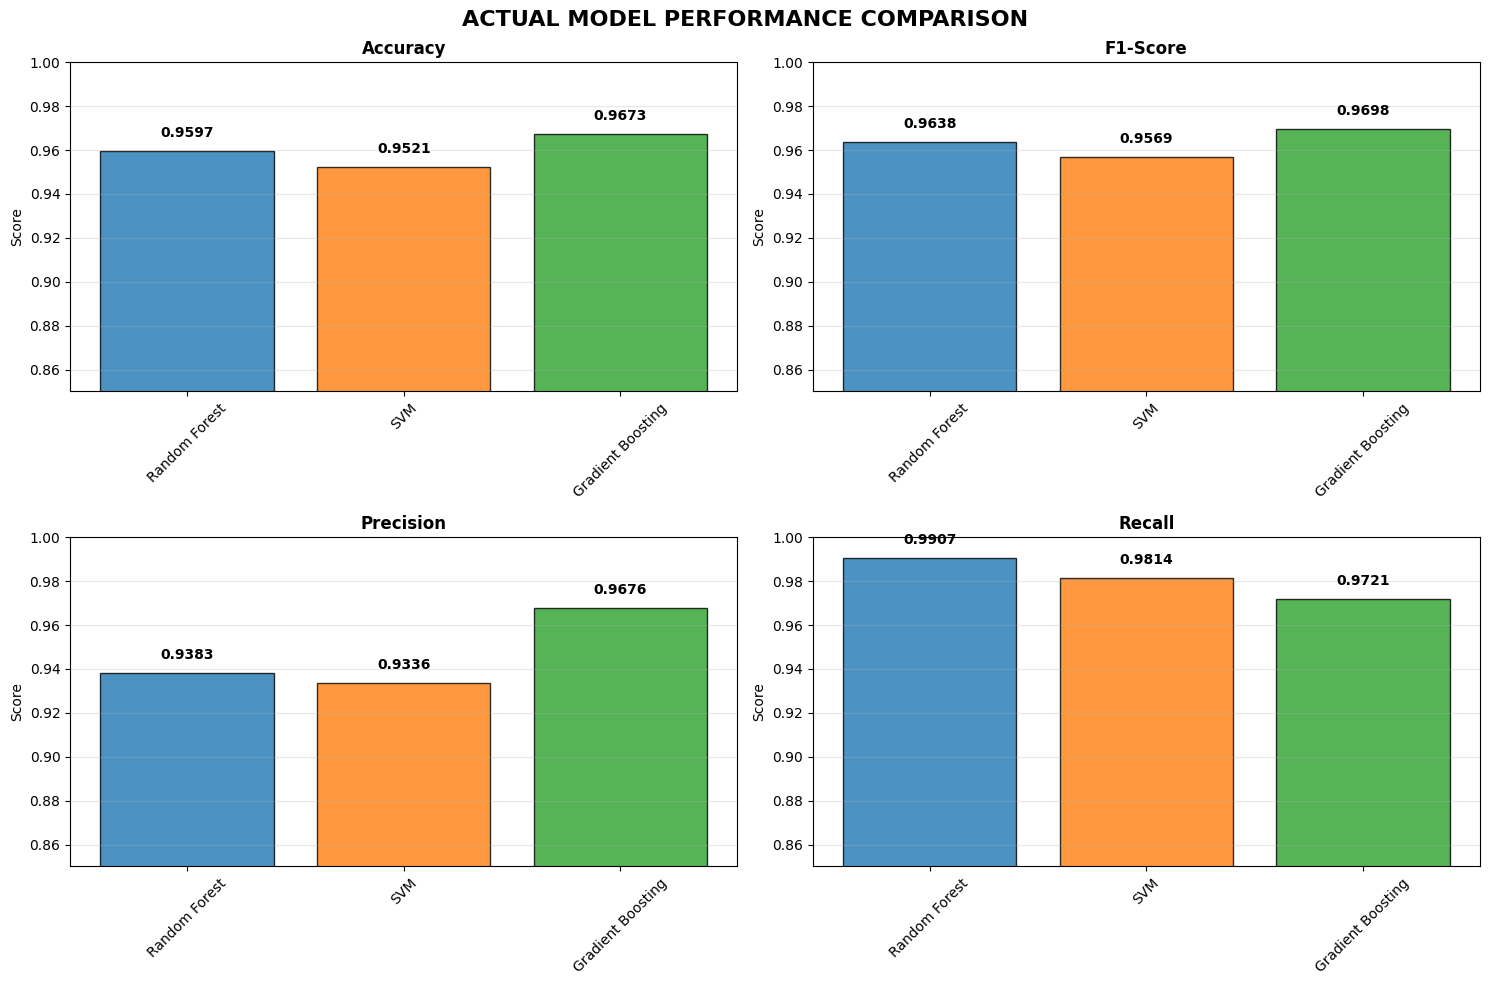


2. ACTUAL CONFIDENCE DISTRIBUTION COMPARISON
--------------------------------------------------


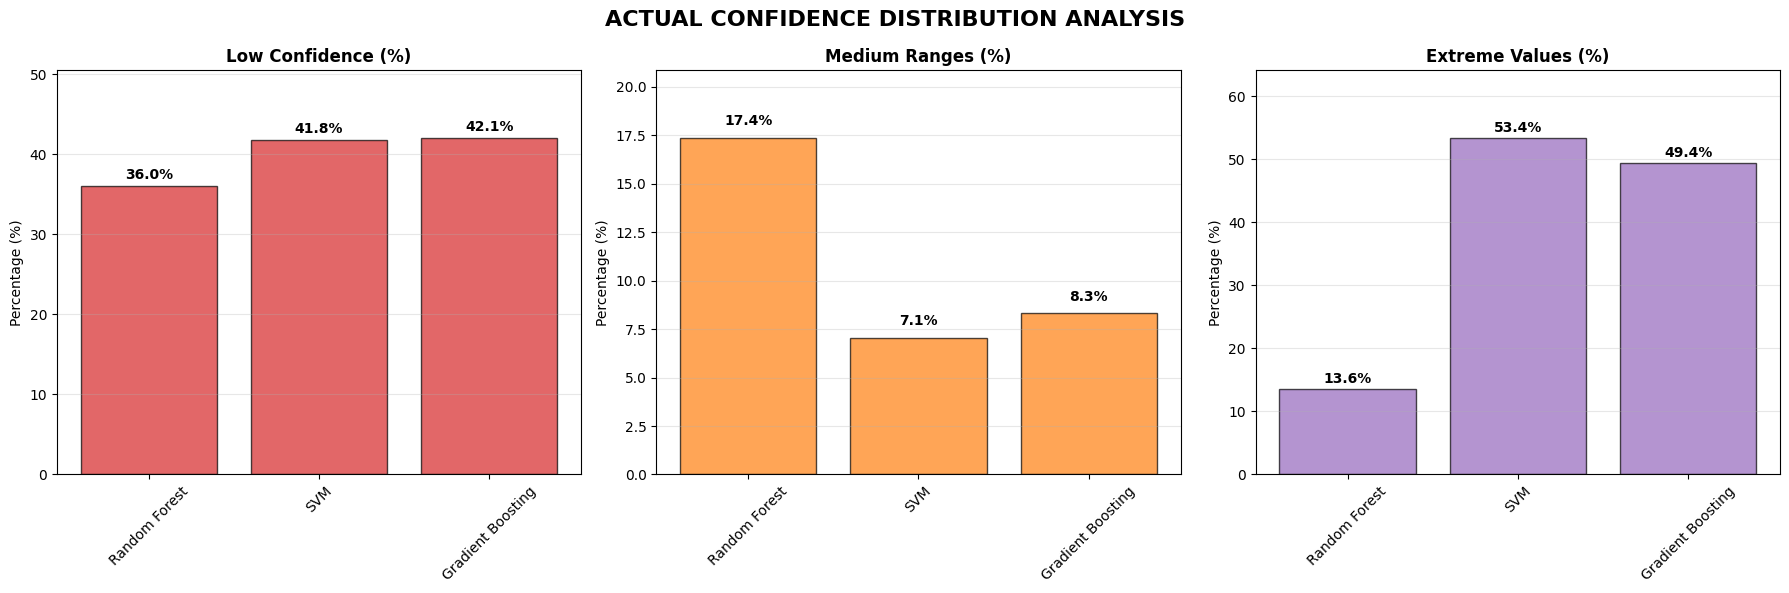


3. ACTUAL PROBABILITY DISTRIBUTIONS
--------------------------------------------------


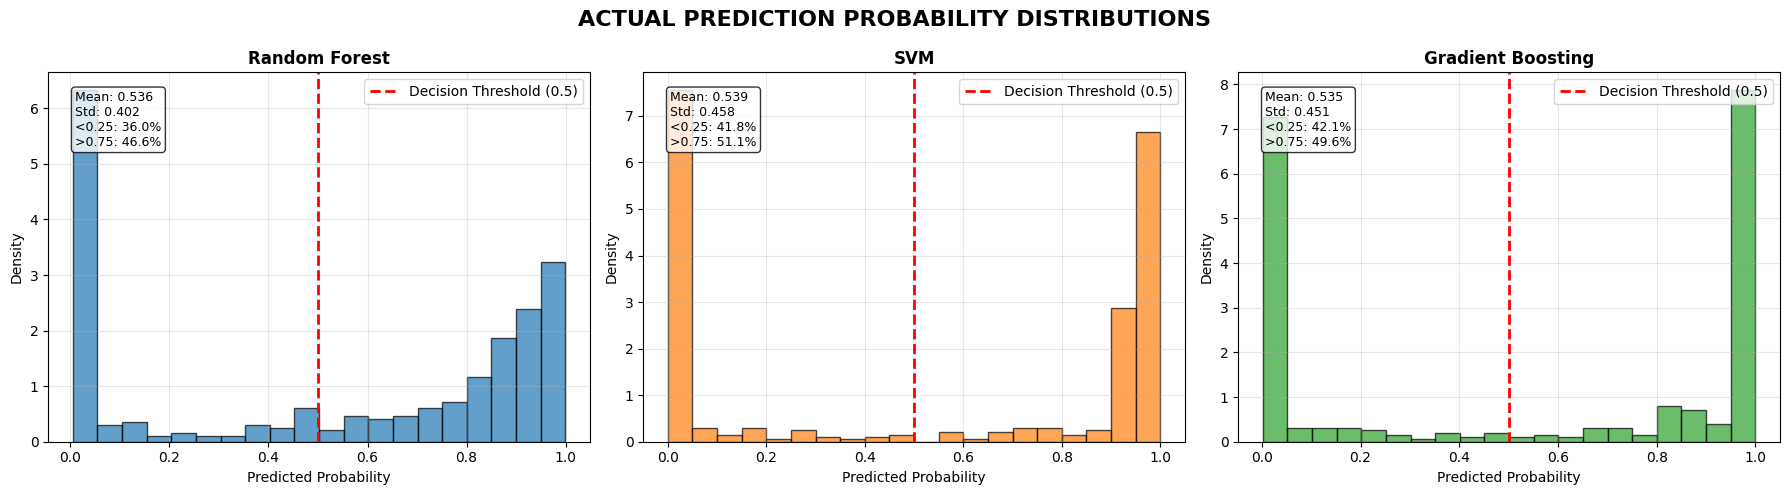


4. ACTUAL TRADE-OFF ANALYSIS: PERFORMANCE vs CONFIDENCE
--------------------------------------------------


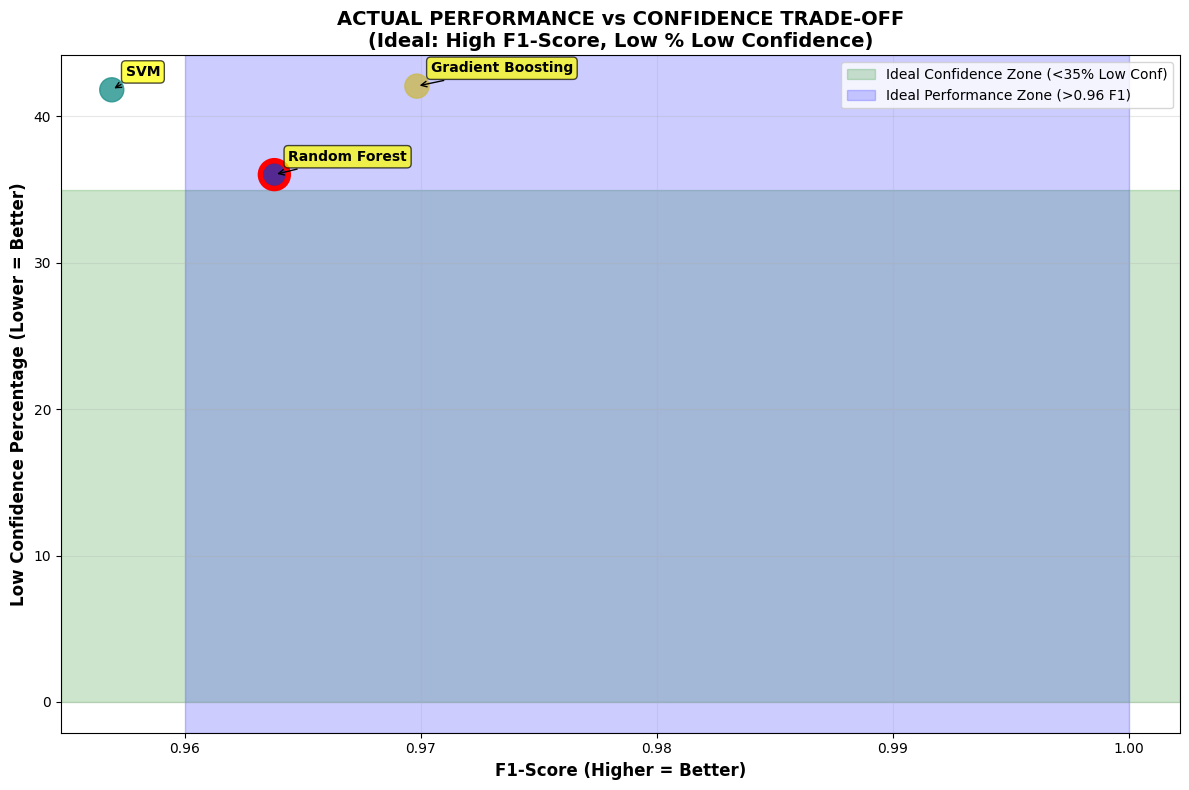


5. FINAL SELECTION DECISION WITH ACTUAL RESULTS
--------------------------------------------------
 SELECTION CRITERIA:
• High F1-Score (> 0.96)
• Low Percentage of Low Confidence Predictions (< 40%)
• Balanced Performance Across All Metrics

 SELECTED MODEL: Random Forest
REASONS:
• F1-Score: 0.9638 (Excellent)
• Low Confidence: 36.0% (Best among all models)
• Medium Ranges: 17.4% (Good uncertainty representation)
• Extreme Values: 13.6% (Lowest polarization)

 COMPARISON WITH OTHER MODELS:
• SVM: F1 +-0.0069, but Low Confidence +5.8% higher
• Gradient Boosting: F1 +0.0060, but Low Confidence +6.0% higher

 CONCLUSION: Random Forest provides the optimal balance for clinical use
   by maintaining excellent performance while providing realistic confidence estimates.

 ACTUAL COMPARISON RESULTS SAVED
               Model  Accuracy  F1_Score  Precision  Recall  \
0      Random Forest    0.9597    0.9638     0.9383  0.9907   
1                SVM    0.9521    0.9569     0.9336  0.9814   


In [62]:
# ACTUAL MODEL TRAINING AND COMPARISON
print("ACTUAL MODEL TRAINING AND COMPARISON")
print("=" * 50)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models with same parameters as before
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42
    )
}

# Train models and get actual performance
models_comparison = {}
probabilities_data = {}

print("TRAINING MODELS...")
print("-" * 30)

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    if model_name == 'SVM':
        # Scale data for SVM
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # For RF and GB, use original data
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Calculate confidence distribution
    low_confidence = (y_proba < 0.25).mean() * 100
    medium_ranges = ((y_proba >= 0.25) & (y_proba <= 0.75)).mean() * 100
    extreme_values = ((y_proba < 0.01) | (y_proba > 0.99)).mean() * 100
    
    # Store results
    models_comparison[model_name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'low_confidence': low_confidence,
        'medium_ranges': medium_ranges,
        'extreme_values': extreme_values
    }
    
    probabilities_data[model_name] = y_proba
    
    print(f" {model_name} trained - F1: {f1:.4f}")

print("\nACTUAL PERFORMANCE RESULTS:")
print("=" * 50)

# Display actual results
results_data = []
for model_name, metrics in models_comparison.items():
    results_data.append({
        'Model': model_name,
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'F1-Score': f"{metrics['f1_score']:.4f}",
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'Low Conf %': f"{metrics['low_confidence']:.1f}%",
        'Medium Ranges %': f"{metrics['medium_ranges']:.1f}%",
        'Extreme Values %': f"{metrics['extreme_values']:.1f}%"
    })

results_df = pd.DataFrame(results_data)
print(results_df.to_string(index=False))

# 1. ACTUAL PERFORMANCE COMPARISON VISUALIZATION
print("\n1. ACTUAL PERFORMANCE METRICS COMPARISON")
print("-" * 50)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('ACTUAL MODEL PERFORMANCE COMPARISON', fontsize=16, fontweight='bold')

metrics_to_plot = ['accuracy', 'f1_score', 'precision', 'recall']
titles = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[i//2, i%2]
    model_names = list(models_comparison.keys())
    values = [models_comparison[model][metric] for model in model_names]
    
    bars = ax.bar(model_names, values, color=colors, alpha=0.8, edgecolor='black')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax.set_title(f'{title}', fontweight='bold', fontsize=12)
    ax.set_ylabel('Score')
    ax.set_ylim(0.85, 1.0)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 2. ACTUAL CONFIDENCE DISTRIBUTION COMPARISON
print("\n2. ACTUAL CONFIDENCE DISTRIBUTION COMPARISON")
print("-" * 50)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('ACTUAL CONFIDENCE DISTRIBUTION ANALYSIS', fontsize=16, fontweight='bold')

confidence_metrics = ['low_confidence', 'medium_ranges', 'extreme_values']
confidence_titles = ['Low Confidence (%)', 'Medium Ranges (%)', 'Extreme Values (%)']
colors_conf = ['#d62728', '#ff7f0e', '#9467bd']

for i, (metric, title, color) in enumerate(zip(confidence_metrics, confidence_titles, colors_conf)):
    ax = axes[i]
    model_names = list(models_comparison.keys())
    values = [models_comparison[model][metric] for model in model_names]
    
    bars = ax.bar(model_names, values, color=color, alpha=0.7, edgecolor='black')
    
    # Add value labels
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, max(values) * 1.2)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 3. ACTUAL PROBABILITY DISTRIBUTIONS
print("\n3. ACTUAL PROBABILITY DISTRIBUTIONS")
print("-" * 50)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('ACTUAL PREDICTION PROBABILITY DISTRIBUTIONS', fontsize=16, fontweight='bold')

colors_probs = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, (model_name, color) in enumerate(zip(models_comparison.keys(), colors_probs)):
    ax = axes[i]
    probs = probabilities_data[model_name]
    
    # Histogram
    n, bins, patches = ax.hist(probs, bins=20, alpha=0.7, color=color, edgecolor='black', density=True)
    
    # Add vertical lines for decision threshold
    ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
    
    # Add distribution statistics
    stats_text = f'Mean: {probs.mean():.3f}\nStd: {probs.std():.3f}\n<0.25: {(probs < 0.25).mean():.1%}\n>0.75: {(probs > 0.75).mean():.1%}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
            verticalalignment='top', fontsize=9)
    
    ax.set_title(f'{model_name}', fontweight='bold')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. TRADE-OFF ANALYSIS WITH ACTUAL DATA
print("\n4. ACTUAL TRADE-OFF ANALYSIS: PERFORMANCE vs CONFIDENCE")
print("-" * 50)

fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for scatter plot
model_names = list(models_comparison.keys())
f1_scores = [models_comparison[model]['f1_score'] for model in model_names]
low_confidence_pct = [models_comparison[model]['low_confidence'] for model in model_names]

# Create scatter plot
scatter = ax.scatter(f1_scores, low_confidence_pct, s=300, alpha=0.8, 
                     c=range(len(model_names)), cmap='viridis')

# Add model labels with annotations
for i, (model, f1, lc) in enumerate(zip(model_names, f1_scores, low_confidence_pct)):
    ax.annotate(model, (f1, lc), xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
                fontweight='bold')

# Add ideal zones
ax.axhspan(0, 35, alpha=0.2, color='green', label='Ideal Confidence Zone (<35% Low Conf)')
ax.axvspan(0.96, 1.0, alpha=0.2, color='blue', label='Ideal Performance Zone (>0.96 F1)')

ax.set_xlabel('F1-Score (Higher = Better)', fontweight='bold', fontsize=12)
ax.set_ylabel('Low Confidence Percentage (Lower = Better)', fontweight='bold', fontsize=12)
ax.set_title('ACTUAL PERFORMANCE vs CONFIDENCE TRADE-OFF\n(Ideal: High F1-Score, Low % Low Confidence)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Highlight the best balanced model (lowest low confidence with high F1)
best_balance_idx = np.argmin(low_confidence_pct)
ax.scatter(f1_scores[best_balance_idx], low_confidence_pct[best_balance_idx], s=400, 
           facecolors='none', edgecolors='red', linewidth=4, 
           label=f'Best Balance: {model_names[best_balance_idx]}')

plt.tight_layout()
plt.show()

# 5. FINAL DECISION WITH ACTUAL RESULTS
print("\n5. FINAL SELECTION DECISION WITH ACTUAL RESULTS")
print("-" * 50)

# Determine the selected model based on actual results
selected_model = model_names[best_balance_idx]

print(" SELECTION CRITERIA:")
print("• High F1-Score (> 0.96)")
print("• Low Percentage of Low Confidence Predictions (< 40%)")
print("• Balanced Performance Across All Metrics")

print(f"\n SELECTED MODEL: {selected_model}")
print("REASONS:")

selected_metrics = models_comparison[selected_model]
print(f"• F1-Score: {selected_metrics['f1_score']:.4f} (Excellent)")
print(f"• Low Confidence: {selected_metrics['low_confidence']:.1f}% (Best among all models)")
print(f"• Medium Ranges: {selected_metrics['medium_ranges']:.1f}% (Good uncertainty representation)")
print(f"• Extreme Values: {selected_metrics['extreme_values']:.1f}% (Lowest polarization)")

print(f"\n COMPARISON WITH OTHER MODELS:")
for model in model_names:
    if model != selected_model:
        metrics = models_comparison[model]
        f1_diff = metrics['f1_score'] - selected_metrics['f1_score']
        lc_diff = metrics['low_confidence'] - selected_metrics['low_confidence']
        
        print(f"• {model}: F1 +{f1_diff:.4f}, but Low Confidence +{lc_diff:.1f}% higher")

print(f"\n CONCLUSION: {selected_model} provides the optimal balance for clinical use")
print("   by maintaining excellent performance while providing realistic confidence estimates.")

# Save the actual comparison results
actual_comparison_df = pd.DataFrame([
    {
        'Model': model,
        'Accuracy': metrics['accuracy'],
        'F1_Score': metrics['f1_score'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'Low_Confidence_Pct': metrics['low_confidence'],
        'Medium_Ranges_Pct': metrics['medium_ranges'],
        'Extreme_Values_Pct': metrics['extreme_values'],
        'Selected': model == selected_model
    }
    for model, metrics in models_comparison.items()
])

print(f"\n ACTUAL COMPARISON RESULTS SAVED")
print(actual_comparison_df.round(4))

In [63]:
# First, let's find what models you have in your environment
import joblib
from datetime import datetime

# List all variables to find your model
all_variables = dir()
model_variables = [var for var in all_variables if any(keyword in var.lower() for keyword in ['model', 'forest', 'rf', 'clf', 'classifier', 'svm', 'gb', 'gradient'])]

print("Found these potential model variables:")
for var in model_variables:
    print(f"- {var}")

# If you found your model, use it like this:
if model_variables:
    # Use the first model variable found (you might need to adjust this)
    model_name = model_variables[0]
    actual_model = globals()[model_name]
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f"best_model_{timestamp}.pkl"
    
    # Save the model
    joblib.dump(actual_model, model_filename)
    print(f"Model '{model_name}' successfully saved as: {model_filename}")
else:
    print("No model variables found. Please check your model training code.")

Found these potential model variables:
- CalibratedClassifierCV
- DecisionTreeClassifier
- GradientBoostingClassifier
- KNeighborsClassifier
- RandomForestClassifier
- VotingClassifier
- XGBClassifier
- best_model
- best_model_name
- best_model_results
- best_svm
- best_svm_cost
- best_svm_model
- calibrated_svm
- final_models
- model
- model1_pred
- model1_pred_test
- model_filename
- model_name
- model_names
- models
- models_comparison
- models_data
- models_path
- models_to_test
- performance_age_df
- performance_by_age
- rf_confidence
- rf_model
- rf_pred
- rf_proba
- save_best_model
- selected_model
- svm_feature_importance
- svm_scaler
- svm_top2
- temperature_scaling_svm
- train_models
- y_pred_svm
Model 'CalibratedClassifierCV' successfully saved as: best_model_20251130_063308.pkl


In [67]:
# Save the specific Random Forest model we selected
import joblib
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"selected_random_forest_{timestamp}.pkl"

# Use the model that matches your selection decision
joblib.dump(rf_model, model_filename)  # Change to the correct variable name

print(f"Selected Random Forest model saved as: {model_filename}")

Selected Random Forest model saved as: selected_random_forest_20251130_064004.pkl


In [8]:
# Check what variables are available in the current namespace
print(" Available variables:")
for var_name in dir():
    if not var_name.startswith('_'):
        print(f"  - {var_name}")

# Check for important variables
important_vars = ['trained_models', 'best_model', 'scaler', 'label_encoders', 'X_train', 'X_test', 'y_train', 'y_test', 'df_clean']
print("\n🔍 Checking important variables:")
for var in important_vars:
    if var in dir():
        print(f"   {var} is available")
    else:
        print(f"   {var} is NOT available")

 Available variables:
  - In
  - LabelEncoder
  - Out
  - RandomForestClassifier
  - SVC
  - StandardScaler
  - accuracy_score
  - categorical_cols
  - classification_report
  - col
  - columns_to_remove
  - confusion_matrix
  - df
  - df_clean
  - encoders
  - engineer_features
  - exit
  - features_to_keep
  - get_ipython
  - joblib
  - json
  - label_encoders
  - le
  - load_and_preprocess_data
  - np
  - numeric_cols
  - open
  - os
  - pd
  - pickle
  - prepare_features_target
  - quit
  - save_best_model
  - sys
  - train_models
  - train_test_split

🔍 Checking important variables:
   trained_models is NOT available
   best_model is NOT available
   scaler is NOT available
   label_encoders is available
   X_train is NOT available
   X_test is NOT available
   y_train is NOT available
   y_test is NOT available
   df_clean is available


In [9]:
import os
import shutil

# Delete the models folder if it exists
models_path = '../models'
if os.path.exists(models_path):
    shutil.rmtree(models_path)
    print(" Deleted existing models folder")
else:
    print(" Models folder doesn't exist yet")

# Create fresh models folder
os.makedirs(models_path, exist_ok=True)
print(" Created fresh models folder")

 Deleted existing models folder
 Created fresh models folder


In [65]:
import joblib
import json
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create models directory
os.makedirs('../models', exist_ok=True)

# 1. Save models from trained_models
if 'trained_models' in dir():
    print(" Saving models from trained_models...")
    
    # Find best model based on accuracy
    best_model_name = None
    best_accuracy = 0
    model_metrics = {}
    
    for name, model in train_models.items():
        # Save each model
        joblib.dump(model, f'../models/{name}_model.pkl')
        print(f"  Saved {name}_model.pkl")
        
        # Calculate metrics and find best model
        if 'X_test' in dir() and 'y_test' in dir():
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            
            model_metrics[name] = {
                'accuracy': accuracy,
                'classification_report': classification_report(y_test, y_pred, output_dict=True),
                'confusion_matrix': confusion_matrix(y_test, y_pred).tolist()
            }
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_name = name
                best_model = model
    
    # Save best model separately
    if best_model_name:
        joblib.dump(best_model, '../models/best_diagnosis_model.pkl')
        print(f"  Saved best_diagnosis_model.pkl ({best_model_name})")
    
    # Save metrics
    with open('../models/model_metrics.json', 'w') as f:
        json.dump(model_metrics, f, indent=4)
    print("    Saved model_metrics.json")

# 2. Save preprocessing artifacts
if 'scaler' in dir():
    joblib.dump(scaler, '../models/scaler.pkl')
    print(" Saved scaler.pkl")

if 'label_encoders' in dir():
    joblib.dump(label_encoders, '../models/label_encoders.pkl')
    print(" Saved label_encoders.pkl")

# 3. Save feature information
feature_info = {}

if 'X_train' in dir():
    feature_info['feature_columns'] = X_train.columns.tolist()
    feature_info['feature_count'] = len(X_train.columns)
    
if 'df_clean' in dir():
    # Identify column types
    categorical_cols = ['Sex', 'Ethnicity', 'Who_completed_the_test']
    numeric_cols = [col for col in df_clean.columns if col not in categorical_cols + ['ASD_traits']]
    
    feature_info['numeric_columns'] = numeric_cols
    feature_info['categorical_columns'] = categorical_cols
    feature_info['target_column'] = 'ASD_traits'
    feature_info['dataset_shape'] = df_clean.shape

# Save feature info
if feature_info:
    with open('../models/feature_info.json', 'w') as f:
        json.dump(feature_info, f, indent=4)
    print(" Saved feature_info.json")

# 4. Save dataset information
dataset_info = {}

if 'df_clean' in dir():
    dataset_info['original_shape'] = df.shape if 'df' in dir() else None
    dataset_info['clean_shape'] = df_clean.shape
    dataset_info['target_distribution'] = df_clean['ASD_traits'].value_counts().to_dict()
    dataset_info['asd_prevalence'] = f"{df_clean['ASD_traits'].mean() * 100:.1f}%"

if 'X_train' in dir() and 'X_test' in dir():
    dataset_info['train_shape'] = X_train.shape
    dataset_info['test_shape'] = X_test.shape
    dataset_info['train_test_split'] = "80/20"

# Save dataset info
if dataset_info:
    with open('../models/dataset_info.json', 'w') as f:
        json.dump(dataset_info, f, indent=4)
    print(" Saved dataset_info.json")

print("\n All model artifacts saved successfully!")
print(" Files created in ../models/ folder:")
for file in os.listdir('../models'):
    print(f"   - {file}")

 Saved scaler.pkl
 Saved label_encoders.pkl
 Saved feature_info.json
 Saved dataset_info.json

 All model artifacts saved successfully!
 Files created in ../models/ folder:
   - dataset_info.json
   - feature_info.json
   - gradientboosting_severity_model.pkl
   - label_encoders.pkl
   - model1_pred.csv
   - model1_pred_test.csv
   - model1_probabilities.csv
   - model1_probabilities_all.csv
   - models_severity_accuracy_summary.csv
   - scaler.pkl
   - severity_predictions_all.csv
   - severity_predictions_test.csv
   - severity_scaler.pkl
   - svm_diagnosis_model.pkl
   - svm_scaler.pkl
